# Sieci konwolucyjne

Zadanie dla Państwa na te ćwiczenia to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [1]:
try:
    # one of the ways to check if our notebook is running inside google colab
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/gmum/ml2025-26.git
    import sys
    sys.path.append('/content/ml2025-26/lab')

fatal: destination path 'ml2025-26' already exists and is not an empty directory.


In [2]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import torch

%matplotlib inline

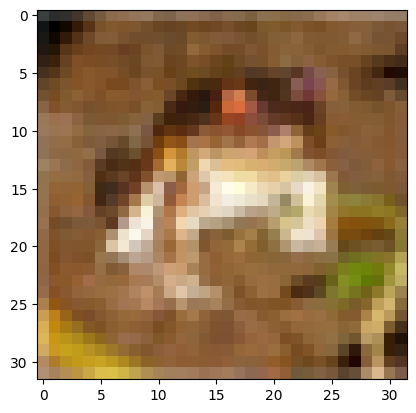

In [3]:
# data loading
if IN_COLAB:
    cifar_sample = np.load("/content/ml2025-26/lab/resources/cifar_sample.npy")
else:
    cifar_sample = np.load("resources/cifar_sample.npy")

# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1, 2, 0))

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważamy tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = K $  

$ \hspace{140px} H_o =  \frac{H_i - F + 2P}{S} + 1  $

$ \hspace{140px} W_o = \frac{W_i - F + 2P}{S} + 1 $  

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?   

$ ( F \times F \times C_f + 1 ) \times K $

### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

![cnn.gif](https://raw.githubusercontent.com/gmum/ml2025-26/main/lab/resources/cnn.gif)

### Zadanie 1:  Konwolucja (5 pkt.)
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazka 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używać pętli).

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który jest podobny do konwolucji, ale mniej skomplikowany.

In [3]:
def convolution(image: torch.tensor,
                filters: torch.tensor,
                bias: torch.tensor,
                stride: int = 1,
                padding: int = 1):
    """
    :param image: torch.Tensor
        Input image of shape (C, H, W)
    :param filters: torch.Tensor
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    n_filters, filter_channels, filter_size, filter_size = filters.shape
    # calculate the dimensions of the output image
    out_height = int((img_height - filter_size + 2 * padding) / stride) + 1
    out_width = int((img_width - filter_size + 2 * padding) / stride) + 1
    out_channels = n_filters
    conv_out = torch.empty((out_channels, out_height, out_width))
    padded_image = torch.tensor(np.pad(
    image,
    pad_width=((0, 0), (padding, padding), (padding, padding)),
    mode='constant',
    constant_values=0))

    for i_h in range(out_height):
      for i_w in range(out_width):
        h_start = stride * i_h
        w_start = stride * i_w
        fragment = padded_image[:, h_start:h_start+filter_size, w_start:w_start+filter_size]
        for n, filter in enumerate(filters):
          conv_element = torch.sum(fragment * filter)
          conv_out[n, i_h, i_w] = conv_element
        conv_out[:, i_h, i_w] = conv_out[:, i_h, i_w] + bias

    return conv_out

In [5]:
# Convolution Test

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [
    (torch.randn((2, 3, 3, 3)), torch.randn((2))),
    (torch.randn((2, 3, 5, 5)), torch.randn((2))),
    (torch.randn((5, 3, 1, 1)), torch.randn((5))),
]

# test all combinations
for (filt, bias), stride, padding in product(filters, strides, paddings):
    # your convolution
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.conv2d(
        input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

### Zadanie 2. Max Pooling (2 pkt.)
Operacja *max pooling* jest analogiczna do zwykłej konwolucji, lecz zamiast operacji mnożenia z zadanym filtrem na każdym fragmencie wejścia wykonywana jest funkcja *max*.

In [6]:
def max_pooling(image: torch.tensor,
                kernel_size: int,
                stride: int = 1,
                padding: int = 1):
    """
    :param image: torch.Tensor
        Input image of shape (C, H, W)
    :param kernel_size: int
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # your code here
    out_height = int((img_height - kernel_size + 2 * padding) / stride) + 1
    out_width = int((img_width - kernel_size + 2 * padding) / stride) + 1
    out_channels = img_channels
    conv_out = torch.empty((out_channels, out_height, out_width))
    padded_image = torch.tensor(np.pad(
    image,
    pad_width=((0, 0), (padding, padding), (padding, padding)),
    mode='constant',
    constant_values=0))

    for i_h in range(out_height):
      for i_w in range(out_width):
        h_start = stride * i_h
        w_start = stride * i_w
        fragment = padded_image[:, h_start:h_start+kernel_size, w_start:w_start+kernel_size]
        conv_out[:, i_h, i_w] = torch.max(fragment.reshape(fragment.size(0), -1), dim=1).values

    return conv_out

In [7]:
# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(
        input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

# Trenowanie sieci kowolucyjnych

**Uwaga:** Poniższa część notebooka jest stworzona z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/) (link do przeglądania repozytoriów w colabie: [link](https://colab.research.google.com/github/)), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [4]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import (RandomVerticalFlip, ToTensor)

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

100%|██████████| 170M/170M [00:04<00:00, 42.2MB/s]


CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


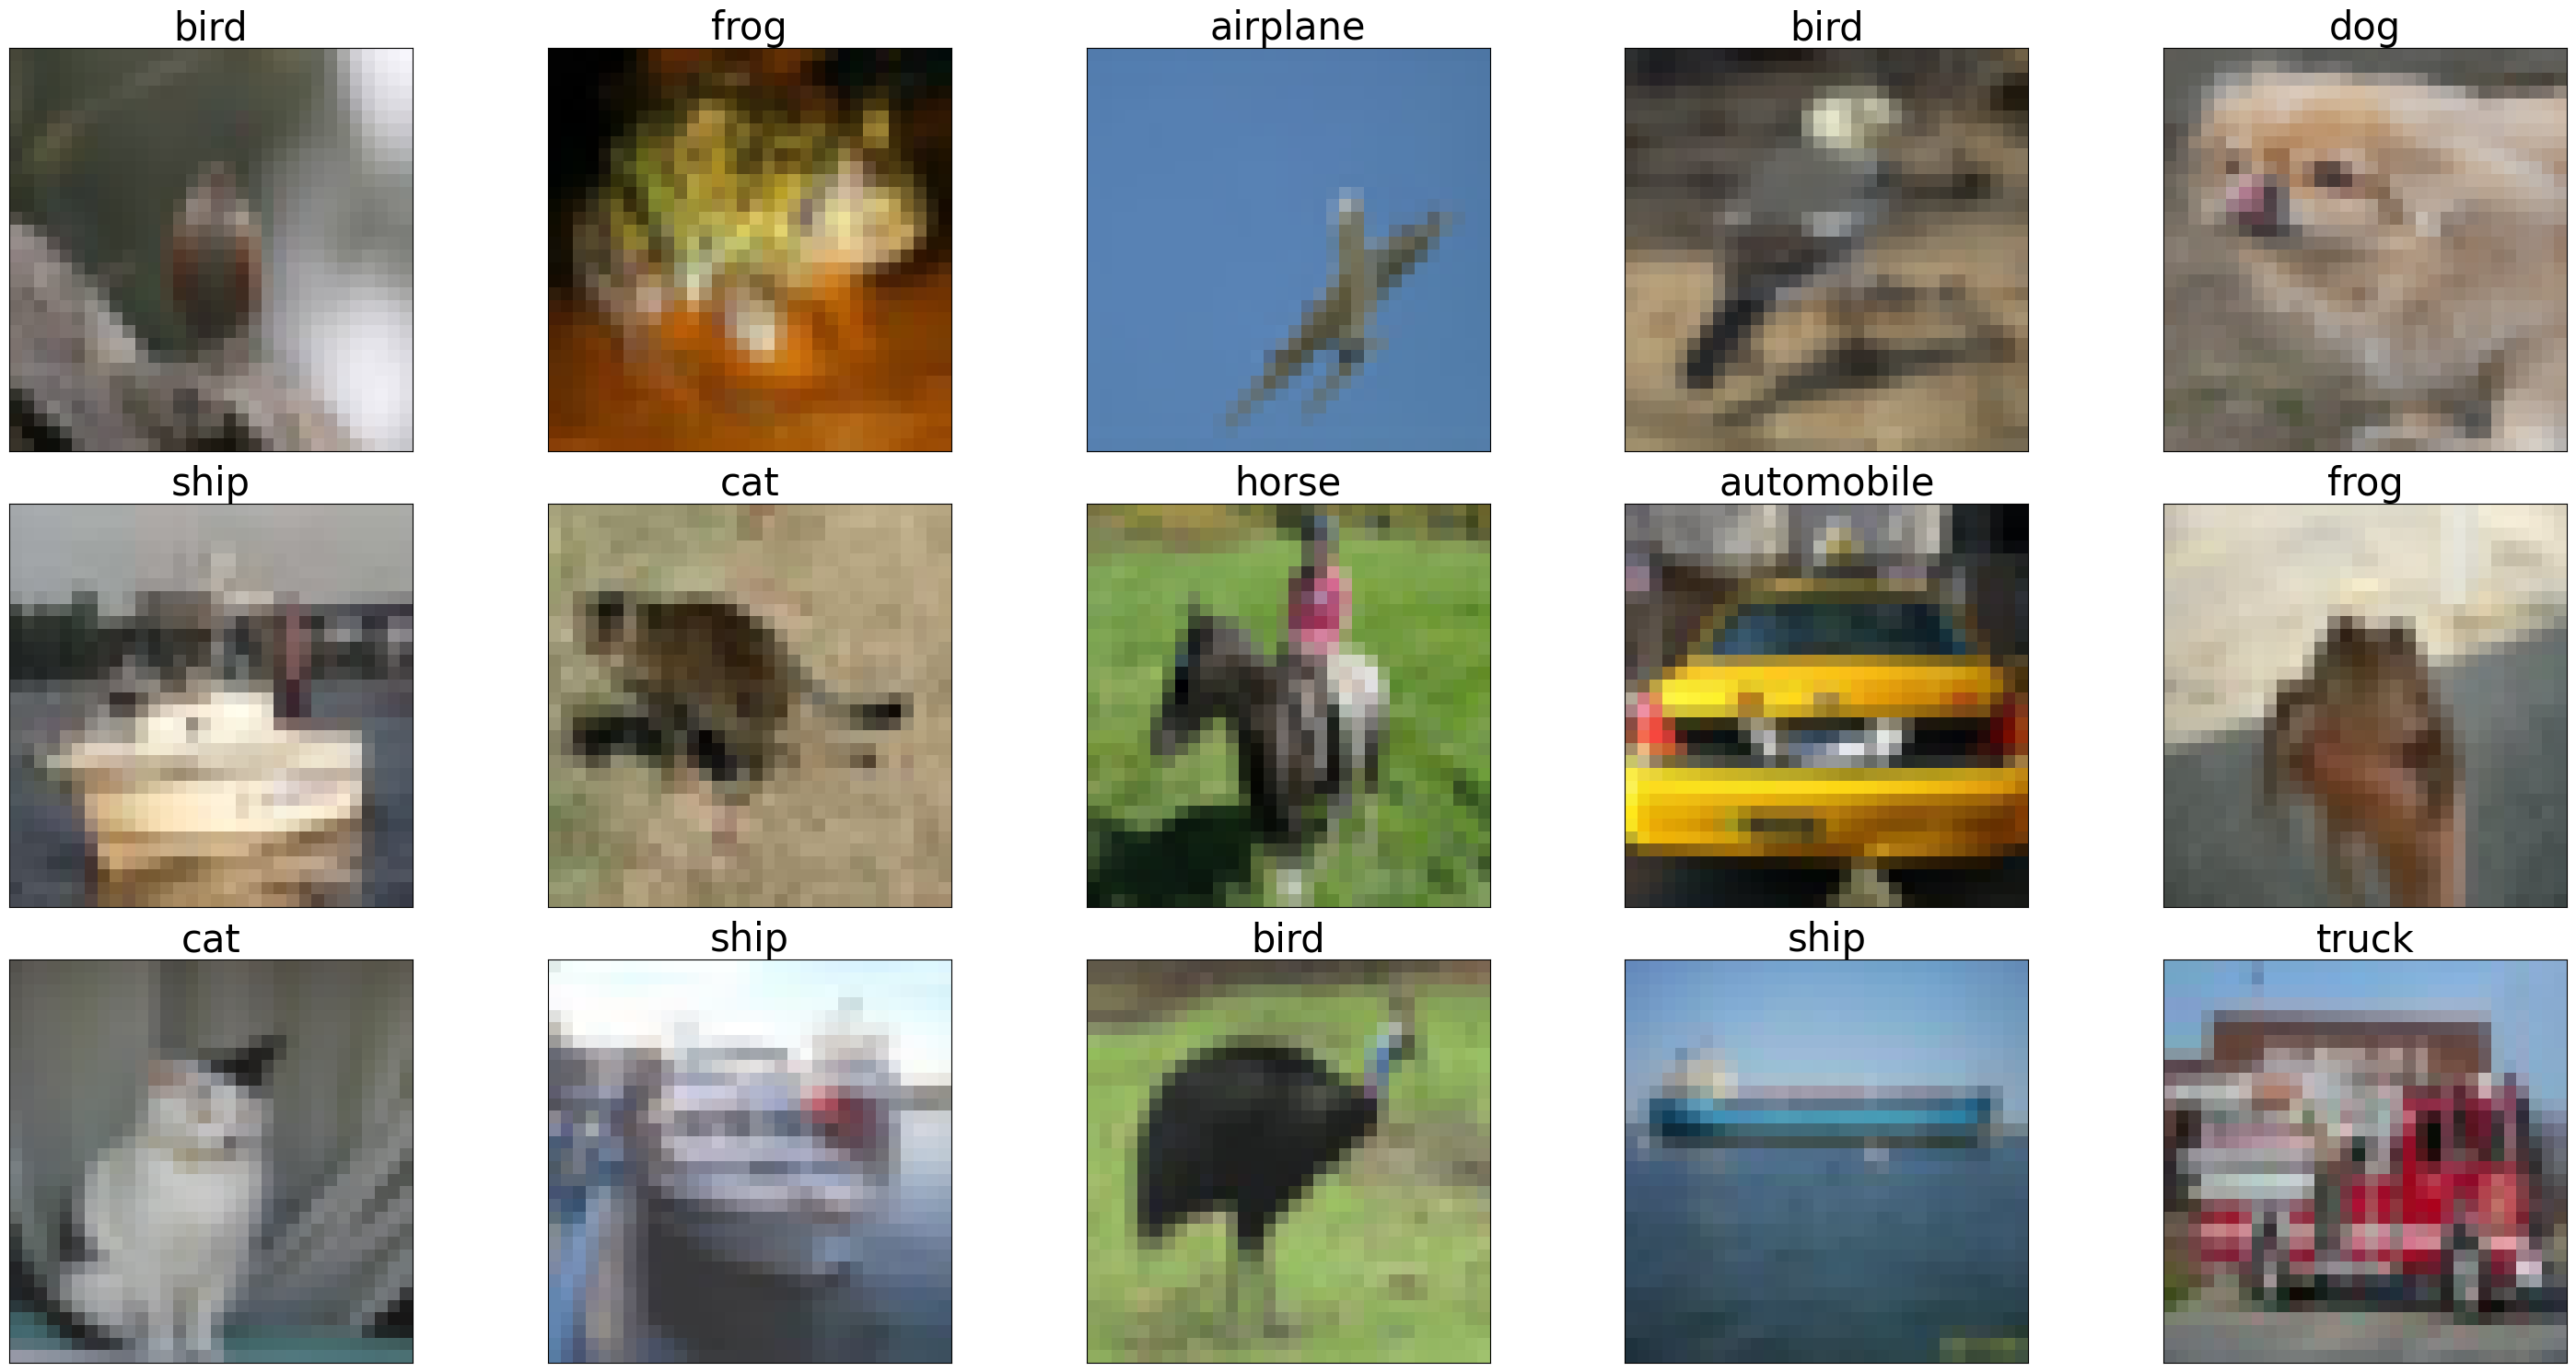

In [9]:
dataset = CIFAR10(root=".", train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={"size": 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 3. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [5]:
from torch import nn
import torch.nn.functional as F

class ConvNet(torch.nn.Module):
    def __init__(self, n_classes, in_channels=3):
        super(ConvNet, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels=256, kernel_size=3, padding=2)
        self.bn_1 = nn.BatchNorm2d(num_features=256)
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3)
        self.bn_2 = nn.BatchNorm2d(num_features=128)
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        self.bn_3 = nn.BatchNorm2d(num_features=128)
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc_1 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.pool_2(x)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = F.relu(x)
        x = self.pool_3(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc_1(x)
        return x


In [6]:
# tutaj uzupełnij ładowanie danych treningowych i testowych
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.4914, 0.4822, 0.4465),
                 (0.247, 0.243, 0.261))
])

train_dataset_full = CIFAR10(root='.',
                             train=True,
                             download=True,
                             transform=transforms)

test_dataset = CIFAR10(root='.',
                       train=False,
                       download=True,
                       transform=transforms)

val_ratio = 0.1
train_size = int((1 - val_ratio) * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

train_dataset, val_dataset = random_split(
    train_dataset_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [11]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = 0

    def __call__(self, val_acc, model):
        score = val_acc

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
            self.counter = 0

    def save_checkpoint(self, val_acc, model):
        print(f'Accuracy increased. ({self.val_acc_max:.6f} → {val_acc:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_acc_max = val_acc


In [7]:
from collections.abc import Callable
from tqdm import tqdm


def evaluate(model, test_loader, loss_fn, device):
    correct, numel = 0, 0
    model.eval()
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            output = model(x_test)
            y_pred = torch.argmax(output, dim=1)
            correct += torch.sum(y_pred == y_test).item()
            numel += x_test.shape[0]
        loss = loss_fn(output, y_test)
        train_loss = loss.item()
        epoch_acc = correct / numel
    return train_loss, epoch_acc


def train(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler,
    train_loader: DataLoader,
    val_loader: DataLoader,
    patience: int,
    delta: float,
    loss_fn: Callable = torch.nn.functional.cross_entropy,
    n_epochs: int = 100,
) -> dict[str, list[float]]:
    logs = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
    }
    device = "cuda" if torch.cuda.is_available() else "cpu"
    early_stopping = EarlyStopping(patience=patience, delta=delta)

    print(f"Device: {device}")
    model = model.to(device)
    correct, numel = 0, 0
    for e in range(1, n_epochs + 1):
        print(f"EPOCH {e}")
        model.train()
        for x, y in tqdm(train_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            y_pred = torch.argmax(output, dim=1)
            correct += torch.sum(y_pred == y).item()
            numel += x.shape[0]
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
        scheduler.step()
        train_loss, epoch_acc = evaluate(model, val_loader, loss_fn, device)

        logs["train_loss"].append(train_loss)
        logs["train_accuracy"].append(epoch_acc)
        print(f"Training loss: {train_loss}, Training accuracy: {epoch_acc}")

        test_loss = loss.item()
        test_acc = correct / numel
        logs["val_loss"].append(test_loss)
        logs["val_accuracy"].append(test_acc)
        print(f"Val loss: {test_loss}, Val accuracy: {test_acc}")

        early_stopping(test_acc, model)

        if early_stopping.early_stop:
          print("Early stopping triggered!")
          break

    return logs

In [14]:
model = ConvNet(n_classes=10)
params = model.parameters()
learning_rate = 0.01
patience = 5
delta = 1e-2
optim = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)

logs = train(model, optim, scheduler, train_loader, val_loader, patience, delta)

Device: cuda
EPOCH 1


100%|██████████| 704/704 [00:18<00:00, 38.48it/s]


Training loss: 0.6178630590438843, Training accuracy: 0.605
Val loss: 0.7039014101028442, Val accuracy: 0.5127777777777778
Accuracy increased. (0.000000 → 0.512778). Saving model...
EPOCH 2


100%|██████████| 704/704 [00:16<00:00, 42.13it/s]


Training loss: 1.1358914375305176, Training accuracy: 0.6534
Val loss: 0.783751368522644, Val accuracy: 0.5931333333333333
Accuracy increased. (0.512778 → 0.593133). Saving model...
EPOCH 3


100%|██████████| 704/704 [00:16<00:00, 42.71it/s]


Training loss: 0.36381107568740845, Training accuracy: 0.7244
Val loss: 0.706314742565155, Val accuracy: 0.6411925925925926
Accuracy increased. (0.593133 → 0.641193). Saving model...
EPOCH 4


100%|██████████| 704/704 [00:15<00:00, 44.74it/s]


Training loss: 1.0393203496932983, Training accuracy: 0.7236
Val loss: 1.2753666639328003, Val accuracy: 0.6758555555555555
Accuracy increased. (0.641193 → 0.675856). Saving model...
EPOCH 5


100%|██████████| 704/704 [00:16<00:00, 43.19it/s]


Training loss: 0.5751326084136963, Training accuracy: 0.7306
Val loss: 1.225536584854126, Val accuracy: 0.7042088888888889
Accuracy increased. (0.675856 → 0.704209). Saving model...
EPOCH 6


100%|██████████| 704/704 [00:15<00:00, 44.37it/s]


Training loss: 0.2134268879890442, Training accuracy: 0.7694
Val loss: 0.1835230439901352, Val accuracy: 0.7292185185185185
Accuracy increased. (0.704209 → 0.729219). Saving model...
EPOCH 7


100%|██████████| 704/704 [00:16<00:00, 42.95it/s]


Training loss: 0.5376724004745483, Training accuracy: 0.754
Val loss: 0.48333925008773804, Val accuracy: 0.7520920634920635
Accuracy increased. (0.729219 → 0.752092). Saving model...
EPOCH 8


100%|██████████| 704/704 [00:15<00:00, 44.01it/s]


Training loss: 0.3533572852611542, Training accuracy: 0.7598
Val loss: 0.9658644199371338, Val accuracy: 0.7726861111111111
Accuracy increased. (0.752092 → 0.772686). Saving model...
EPOCH 9


100%|██████████| 704/704 [00:16<00:00, 42.80it/s]


Training loss: 0.49938133358955383, Training accuracy: 0.7632
Val loss: 0.4237939417362213, Val accuracy: 0.7910518518518519
Accuracy increased. (0.772686 → 0.791052). Saving model...
EPOCH 10


100%|██████████| 704/704 [00:16<00:00, 42.58it/s]


Training loss: 1.1071107387542725, Training accuracy: 0.7614
Val loss: 0.8025764226913452, Val accuracy: 0.8078666666666666
Accuracy increased. (0.791052 → 0.807867). Saving model...
EPOCH 11


100%|██████████| 704/704 [00:15<00:00, 44.03it/s]


Training loss: 0.40430933237075806, Training accuracy: 0.7702
Val loss: 1.3302167654037476, Val accuracy: 0.8225616161616162
Accuracy increased. (0.807867 → 0.822562). Saving model...
EPOCH 12


100%|██████████| 704/704 [00:16<00:00, 42.76it/s]


Training loss: 0.1620013266801834, Training accuracy: 0.764
Val loss: 0.008723566308617592, Val accuracy: 0.8356851851851852
Accuracy increased. (0.822562 → 0.835685). Saving model...
EPOCH 13


100%|██████████| 704/704 [00:15<00:00, 44.24it/s]


Training loss: 1.0071396827697754, Training accuracy: 0.7624
Val loss: 0.04373941570520401, Val accuracy: 0.8474068376068377
Accuracy increased. (0.835685 → 0.847407). Saving model...
EPOCH 14


100%|██████████| 704/704 [00:15<00:00, 44.23it/s]


Training loss: 1.0868968963623047, Training accuracy: 0.7642
Val loss: 0.0599244199693203, Val accuracy: 0.857679365079365
Accuracy increased. (0.847407 → 0.857679). Saving model...
EPOCH 15


100%|██████████| 704/704 [00:15<00:00, 44.53it/s]


Training loss: 0.42737627029418945, Training accuracy: 0.7664
Val loss: 0.07110634446144104, Val accuracy: 0.8667555555555555
EarlyStopping counter: 1 out of 5
EPOCH 16


100%|██████████| 704/704 [00:16<00:00, 43.43it/s]


Training loss: 0.5023241639137268, Training accuracy: 0.7684
Val loss: 0.010114509612321854, Val accuracy: 0.8747402777777777
Accuracy increased. (0.857679 → 0.874740). Saving model...
EPOCH 17


100%|██████████| 704/704 [00:15<00:00, 45.05it/s]


Training loss: 0.5417293310165405, Training accuracy: 0.7708
Val loss: 0.28131985664367676, Val accuracy: 0.8818954248366013
EarlyStopping counter: 1 out of 5
EPOCH 18


100%|██████████| 704/704 [00:16<00:00, 43.61it/s]


Training loss: 0.5124416947364807, Training accuracy: 0.7726
Val loss: 0.006694571115076542, Val accuracy: 0.8882012345679012
Accuracy increased. (0.874740 → 0.888201). Saving model...
EPOCH 19


100%|██████████| 704/704 [00:15<00:00, 44.64it/s]


Training loss: 0.6088905930519104, Training accuracy: 0.7724
Val loss: 0.006493136286735535, Val accuracy: 0.8939906432748538
EarlyStopping counter: 1 out of 5
EPOCH 20


100%|██████████| 704/704 [00:16<00:00, 43.55it/s]


Training loss: 0.9837324023246765, Training accuracy: 0.7742
Val loss: 0.302692174911499, Val accuracy: 0.8992566666666667
Accuracy increased. (0.888201 → 0.899257). Saving model...
EPOCH 21


100%|██████████| 704/704 [00:15<00:00, 44.77it/s]


Training loss: 0.7648508548736572, Training accuracy: 0.7752
Val loss: 0.0034652603790163994, Val accuracy: 0.9039566137566137
EarlyStopping counter: 1 out of 5
EPOCH 22


100%|██████████| 704/704 [00:16<00:00, 43.76it/s]


Training loss: 1.1189491748809814, Training accuracy: 0.7748
Val loss: 0.030066249892115593, Val accuracy: 0.9083020202020202
EarlyStopping counter: 2 out of 5
EPOCH 23


100%|██████████| 704/704 [00:15<00:00, 44.05it/s]


Training loss: 0.5562132596969604, Training accuracy: 0.777
Val loss: 0.012203100137412548, Val accuracy: 0.9122840579710145
Accuracy increased. (0.899257 → 0.912284). Saving model...
EPOCH 24


100%|██████████| 704/704 [00:15<00:00, 44.34it/s]


Training loss: 0.4680349826812744, Training accuracy: 0.7782
Val loss: 0.02887069806456566, Val accuracy: 0.9159324074074074
EarlyStopping counter: 1 out of 5
EPOCH 25


100%|██████████| 704/704 [00:15<00:00, 44.12it/s]


Training loss: 0.5271387696266174, Training accuracy: 0.778
Val loss: 0.0024081445299088955, Val accuracy: 0.9192826666666667
EarlyStopping counter: 2 out of 5
EPOCH 26


100%|██████████| 704/704 [00:15<00:00, 44.02it/s]


Training loss: 0.7145407199859619, Training accuracy: 0.7756
Val loss: 0.2035413384437561, Val accuracy: 0.9223675213675213
Accuracy increased. (0.912284 → 0.922368). Saving model...
EPOCH 27


100%|██████████| 704/704 [00:16<00:00, 43.42it/s]


Training loss: 1.0006555318832397, Training accuracy: 0.7748
Val loss: 0.14335721731185913, Val accuracy: 0.9252255144032921
EarlyStopping counter: 1 out of 5
EPOCH 28


100%|██████████| 704/704 [00:15<00:00, 45.37it/s]


Training loss: 0.9041931629180908, Training accuracy: 0.7768
Val loss: 2.1918625861871988e-05, Val accuracy: 0.9278857142857143
EarlyStopping counter: 2 out of 5
EPOCH 29


100%|██████████| 704/704 [00:16<00:00, 43.15it/s]


Training loss: 0.8395047783851624, Training accuracy: 0.7808
Val loss: 0.00042786740232259035, Val accuracy: 0.9303678160919541
EarlyStopping counter: 3 out of 5
EPOCH 30


100%|██████████| 704/704 [00:15<00:00, 44.93it/s]


Training loss: 0.5993799567222595, Training accuracy: 0.7772
Val loss: 0.0015580339822918177, Val accuracy: 0.9326844444444444
Accuracy increased. (0.922368 → 0.932684). Saving model...
EPOCH 31


100%|██████████| 704/704 [00:15<00:00, 44.40it/s]


Training loss: 0.7631982564926147, Training accuracy: 0.7804
Val loss: 0.03517552465200424, Val accuracy: 0.9348537634408602
EarlyStopping counter: 1 out of 5
EPOCH 32


100%|██████████| 704/704 [00:15<00:00, 45.16it/s]


Training loss: 0.6789309978485107, Training accuracy: 0.777
Val loss: 0.6590296626091003, Val accuracy: 0.9368840277777778
EarlyStopping counter: 2 out of 5
EPOCH 33


100%|██████████| 704/704 [00:15<00:00, 44.93it/s]


Training loss: 0.6597455739974976, Training accuracy: 0.7752
Val loss: 0.005881122779101133, Val accuracy: 0.938793265993266
EarlyStopping counter: 3 out of 5
EPOCH 34


100%|██████████| 704/704 [00:16<00:00, 43.57it/s]


Training loss: 0.8482191562652588, Training accuracy: 0.7792
Val loss: 0.7081760168075562, Val accuracy: 0.9405921568627451
EarlyStopping counter: 4 out of 5
EPOCH 35


100%|██████████| 704/704 [00:15<00:00, 45.41it/s]


Training loss: 0.917264997959137, Training accuracy: 0.7778
Val loss: 0.0031119997147470713, Val accuracy: 0.9422869841269841
EarlyStopping counter: 5 out of 5
Early stopping triggered!


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.functional.cross_entropy

best_model = ConvNet(n_classes=10)
best_model.load_state_dict(torch.load('checkpoint.pt'))
best_model.to(device)

test_loss, test_acc = evaluate(best_model, test_loader, loss_fn, device)

print(f"Best model accuracy on test set: {test_acc}")

Best model accuracy on test set: 0.7731


### Zadanie 4 ResNet (2 pkt.)

Zaimplementuj sieć konwolucyjną do klasyfikacji wieloklasowej na zbiorze CIFAR10 z blokami rezydualnymi.
```
Standard Block:  
x → Conv → ReLU → Conv → y  

Residual Block:  
x → Conv → BN → ReLU → Conv → BN → (+) → ReLU → y  
                         ↑  
                         x (identity lub projekcja)
```


In [21]:
class ResNetBlock(torch.nn.Module):
    def __init__(self, n_channels, stride=1, kernel_size=3, use_1x1_conv=False):
        super(ResNetBlock, self).__init__()
        self.conv_1 = nn.LazyConv2d(n_channels, kernel_size=kernel_size, stride=stride, padding=1)
        self.bn_1 = nn.LazyBatchNorm2d()
        self.conv_2 = nn.LazyConv2d(n_channels, kernel_size=kernel_size, padding=1)
        self.bn_2 = nn.LazyBatchNorm2d()
        if use_1x1_conv:
            self.skip_conv = nn.LazyConv2d(n_channels, kernel_size=1, stride=stride)
        else:
            self.skip_conv = None

    def forward(self, x):
        y = self.conv_1(x)
        y = self.bn_1(y)
        y = F.relu(y)
        y = self.conv_2(y)
        y = self.bn_2(y)
        if self.skip_conv:
            x = self.skip_conv(x)
        y += x
        return F.relu(y)


class ResNet(torch.nn.Module):
    def __init__(self, n_classes):
        super(ResNet, self).__init__()
        self.conv_1 = nn.LazyConv2d(128, kernel_size=3, padding=2)
        self.bn_1 = nn.LazyBatchNorm2d()
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.blk_1 = ResNetBlock(128, use_1x1_conv=True)
        self.blk_2 = ResNetBlock(128)
        self.flatten = nn.Flatten()
        self.pool_2 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_1 = nn.LazyLinear(n_classes)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.pool_1(x)
        x = self.blk_1(x)
        x = self.blk_2(x)
        x = self.pool_2(x)
        x = self.flatten(x)
        x = self.fc_1(x)
        return x


In [17]:
model = ResNet(n_classes=10)
params = model.parameters()
learning_rate = 0.01
patience = 5
delta = 1e-2
optim = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)

logs = train(model, optim, scheduler, train_loader, val_loader, patience, delta)

Device: cuda
EPOCH 1


100%|██████████| 704/704 [00:17<00:00, 40.61it/s]


Training loss: 1.0162932872772217, Training accuracy: 0.5154
Val loss: 1.2957510948181152, Val accuracy: 0.44664444444444446
Accuracy increased. (0.000000 → 0.446644). Saving model...
EPOCH 2


100%|██████████| 704/704 [00:17<00:00, 39.71it/s]


Training loss: 0.49706020951271057, Training accuracy: 0.6192
Val loss: 1.3450026512145996, Val accuracy: 0.5335
Accuracy increased. (0.446644 → 0.533500). Saving model...
EPOCH 3


100%|██████████| 704/704 [00:18<00:00, 38.71it/s]


Training loss: 0.7789807915687561, Training accuracy: 0.6558
Val loss: 1.251627802848816, Val accuracy: 0.5858740740740741
Accuracy increased. (0.533500 → 0.585874). Saving model...
EPOCH 4


100%|██████████| 704/704 [00:17<00:00, 40.11it/s]


Training loss: 0.8671684861183167, Training accuracy: 0.7398
Val loss: 1.9078267812728882, Val accuracy: 0.6232777777777778
Accuracy increased. (0.585874 → 0.623278). Saving model...
EPOCH 5


100%|██████████| 704/704 [00:18<00:00, 38.48it/s]


Training loss: 0.6491788029670715, Training accuracy: 0.7602
Val loss: 0.3116709291934967, Val accuracy: 0.6533777777777777
Accuracy increased. (0.623278 → 0.653378). Saving model...
EPOCH 6


100%|██████████| 704/704 [00:18<00:00, 37.87it/s]


Training loss: 0.32523056864738464, Training accuracy: 0.764
Val loss: 0.1934044063091278, Val accuracy: 0.6787592592592593
Accuracy increased. (0.653378 → 0.678759). Saving model...
EPOCH 7


100%|██████████| 704/704 [00:17<00:00, 39.21it/s]


Training loss: 0.40282535552978516, Training accuracy: 0.787
Val loss: 0.8091791868209839, Val accuracy: 0.7012571428571429
Accuracy increased. (0.678759 → 0.701257). Saving model...
EPOCH 8


100%|██████████| 704/704 [00:18<00:00, 38.20it/s]


Training loss: 0.15375515818595886, Training accuracy: 0.8124
Val loss: 0.3054925203323364, Val accuracy: 0.7207666666666667
Accuracy increased. (0.701257 → 0.720767). Saving model...
EPOCH 9


100%|██████████| 704/704 [00:17<00:00, 39.93it/s]


Training loss: 0.5385182499885559, Training accuracy: 0.8042
Val loss: 0.6625974178314209, Val accuracy: 0.7382666666666666
Accuracy increased. (0.720767 → 0.738267). Saving model...
EPOCH 10


100%|██████████| 704/704 [00:18<00:00, 39.08it/s]


Training loss: 0.2923988401889801, Training accuracy: 0.815
Val loss: 0.3566170632839203, Val accuracy: 0.7544266666666667
Accuracy increased. (0.738267 → 0.754427). Saving model...
EPOCH 11


100%|██████████| 704/704 [00:18<00:00, 38.04it/s]


Training loss: 0.3102266192436218, Training accuracy: 0.8132
Val loss: 0.8436262011528015, Val accuracy: 0.7691252525252525
Accuracy increased. (0.754427 → 0.769125). Saving model...
EPOCH 12


100%|██████████| 704/704 [00:18<00:00, 37.51it/s]


Training loss: 0.11539310961961746, Training accuracy: 0.8184
Val loss: 0.7057271003723145, Val accuracy: 0.7828333333333334
Accuracy increased. (0.769125 → 0.782833). Saving model...
EPOCH 13


100%|██████████| 704/704 [00:18<00:00, 37.19it/s]


Training loss: 0.6993924379348755, Training accuracy: 0.8102
Val loss: 0.6113821864128113, Val accuracy: 0.7956495726495727
Accuracy increased. (0.782833 → 0.795650). Saving model...
EPOCH 14


100%|██████████| 704/704 [00:18<00:00, 37.51it/s]


Training loss: 0.08144593983888626, Training accuracy: 0.8228
Val loss: 0.0392611101269722, Val accuracy: 0.8074507936507936
Accuracy increased. (0.795650 → 0.807451). Saving model...
EPOCH 15


100%|██████████| 704/704 [00:17<00:00, 39.94it/s]


Training loss: 0.13142699003219604, Training accuracy: 0.8094
Val loss: 0.001117281848564744, Val accuracy: 0.8183733333333333
Accuracy increased. (0.807451 → 0.818373). Saving model...
EPOCH 16


100%|██████████| 704/704 [00:17<00:00, 39.19it/s]


Training loss: 0.04870237037539482, Training accuracy: 0.8298
Val loss: 0.08113893121480942, Val accuracy: 0.8284597222222222
Accuracy increased. (0.818373 → 0.828460). Saving model...
EPOCH 17


100%|██████████| 704/704 [00:18<00:00, 39.07it/s]


Training loss: 0.04689629375934601, Training accuracy: 0.8292
Val loss: 0.32327309250831604, Val accuracy: 0.8376326797385621
EarlyStopping counter: 1 out of 5
EPOCH 18


100%|██████████| 704/704 [00:17<00:00, 39.82it/s]


Training loss: 0.006231994833797216, Training accuracy: 0.8298
Val loss: 0.03443590924143791, Val accuracy: 0.8459827160493827
Accuracy increased. (0.828460 → 0.845983). Saving model...
EPOCH 19


100%|██████████| 704/704 [00:18<00:00, 38.81it/s]


Training loss: 0.0024263709783554077, Training accuracy: 0.8302
Val loss: 0.33341944217681885, Val accuracy: 0.8536549707602339
EarlyStopping counter: 1 out of 5
EPOCH 20


100%|██████████| 704/704 [00:17<00:00, 39.89it/s]


Training loss: 0.0015243692323565483, Training accuracy: 0.8274
Val loss: 0.021931173279881477, Val accuracy: 0.8605877777777777
Accuracy increased. (0.845983 → 0.860588). Saving model...
EPOCH 21


100%|██████████| 704/704 [00:17<00:00, 40.03it/s]


Training loss: 0.024465341120958328, Training accuracy: 0.8274
Val loss: 0.09666531533002853, Val accuracy: 0.8670169312169312
EarlyStopping counter: 1 out of 5
EPOCH 22


100%|██████████| 704/704 [00:18<00:00, 38.91it/s]


Training loss: 0.01108099240809679, Training accuracy: 0.8368
Val loss: 0.01579250954091549, Val accuracy: 0.8728858585858585
Accuracy increased. (0.860588 → 0.872886). Saving model...
EPOCH 23


100%|██████████| 704/704 [00:17<00:00, 39.98it/s]


Training loss: 0.11024296283721924, Training accuracy: 0.8316
Val loss: 0.23926100134849548, Val accuracy: 0.8782772946859904
EarlyStopping counter: 1 out of 5
EPOCH 24


100%|██████████| 704/704 [00:17<00:00, 39.36it/s]


Training loss: 0.05484568327665329, Training accuracy: 0.833
Val loss: 0.026862967759370804, Val accuracy: 0.8832083333333334
Accuracy increased. (0.872886 → 0.883208). Saving model...
EPOCH 25


100%|██████████| 704/704 [00:17<00:00, 40.03it/s]


Training loss: 0.011773650534451008, Training accuracy: 0.8352
Val loss: 0.004804262891411781, Val accuracy: 0.8878151111111111
EarlyStopping counter: 1 out of 5
EPOCH 26


100%|██████████| 704/704 [00:17<00:00, 40.32it/s]


Training loss: 0.03646508976817131, Training accuracy: 0.8284
Val loss: 0.0446004755795002, Val accuracy: 0.8920794871794872
EarlyStopping counter: 2 out of 5
EPOCH 27


100%|██████████| 704/704 [00:17<00:00, 39.30it/s]


Training loss: 0.0010412660194560885, Training accuracy: 0.8352
Val loss: 0.4428064823150635, Val accuracy: 0.8960395061728396
Accuracy increased. (0.883208 → 0.896040). Saving model...
EPOCH 28


100%|██████████| 704/704 [00:17<00:00, 39.40it/s]


Training loss: 0.0027488647028803825, Training accuracy: 0.8384
Val loss: 0.08315420150756836, Val accuracy: 0.8996793650793651
EarlyStopping counter: 1 out of 5
EPOCH 29


100%|██████████| 704/704 [00:18<00:00, 38.58it/s]


Training loss: 0.0019250457407906651, Training accuracy: 0.835
Val loss: 0.006339069455862045, Val accuracy: 0.9031011494252874
EarlyStopping counter: 2 out of 5
EPOCH 30


100%|██████████| 704/704 [00:18<00:00, 38.56it/s]


Training loss: 0.009461033158004284, Training accuracy: 0.8348
Val loss: 0.46062931418418884, Val accuracy: 0.9063162962962963
Accuracy increased. (0.896040 → 0.906316). Saving model...
EPOCH 31


100%|██████████| 704/704 [00:17<00:00, 40.23it/s]


Training loss: 0.00955419521778822, Training accuracy: 0.8384
Val loss: 0.13661345839500427, Val accuracy: 0.9093096774193549
EarlyStopping counter: 1 out of 5
EPOCH 32


100%|██████████| 704/704 [00:18<00:00, 38.79it/s]


Training loss: 0.0015987654915079474, Training accuracy: 0.8372
Val loss: 0.023888342082500458, Val accuracy: 0.9121243055555556
EarlyStopping counter: 2 out of 5
EPOCH 33


100%|██████████| 704/704 [00:17<00:00, 40.09it/s]


Training loss: 0.0021611752454191446, Training accuracy: 0.8368
Val loss: 0.3566346764564514, Val accuracy: 0.9147818181818181
EarlyStopping counter: 3 out of 5
EPOCH 34


100%|██████████| 704/704 [00:17<00:00, 39.75it/s]


Training loss: 0.0008713384158909321, Training accuracy: 0.8398
Val loss: 0.2038506716489792, Val accuracy: 0.9172692810457517
Accuracy increased. (0.906316 → 0.917269). Saving model...
EPOCH 35


100%|██████████| 704/704 [00:18<00:00, 38.31it/s]


Training loss: 0.04576721787452698, Training accuracy: 0.84
Val loss: 0.003770578419789672, Val accuracy: 0.919624761904762
EarlyStopping counter: 1 out of 5
EPOCH 36


100%|██████████| 704/704 [00:17<00:00, 39.88it/s]


Training loss: 0.06786990910768509, Training accuracy: 0.8402
Val loss: 0.0019153315806761384, Val accuracy: 0.9218487654320988
EarlyStopping counter: 2 out of 5
EPOCH 37


100%|██████████| 704/704 [00:18<00:00, 38.86it/s]


Training loss: 0.001068196608684957, Training accuracy: 0.8402
Val loss: 0.001196310156956315, Val accuracy: 0.923957957957958
EarlyStopping counter: 3 out of 5
EPOCH 38


100%|██████████| 704/704 [00:17<00:00, 39.90it/s]


Training loss: 0.0014555698726326227, Training accuracy: 0.8392
Val loss: 0.0028512966819107533, Val accuracy: 0.9259555555555555
EarlyStopping counter: 4 out of 5
EPOCH 39


100%|██████████| 704/704 [00:17<00:00, 39.93it/s]


Training loss: 0.001271465327590704, Training accuracy: 0.8412
Val loss: 0.007910536602139473, Val accuracy: 0.9278501424501424
Accuracy increased. (0.917269 → 0.927850). Saving model...
EPOCH 40


100%|██████████| 704/704 [00:18<00:00, 38.85it/s]


Training loss: 0.000666759442538023, Training accuracy: 0.839
Val loss: 1.2921067476272583, Val accuracy: 0.9296505555555555
EarlyStopping counter: 1 out of 5
EPOCH 41


100%|██████████| 704/704 [00:17<00:00, 40.02it/s]


Training loss: 0.0018098818836733699, Training accuracy: 0.8382
Val loss: 0.0074452064000070095, Val accuracy: 0.931359349593496
EarlyStopping counter: 2 out of 5
EPOCH 42


100%|██████████| 704/704 [00:18<00:00, 38.66it/s]


Training loss: 0.0020494316704571247, Training accuracy: 0.8406
Val loss: 0.0003549989778548479, Val accuracy: 0.9329888888888889
EarlyStopping counter: 3 out of 5
EPOCH 43


100%|██████████| 704/704 [00:17<00:00, 39.43it/s]


Training loss: 0.0008808556012809277, Training accuracy: 0.8412
Val loss: 0.000250327808316797, Val accuracy: 0.9345447028423772
EarlyStopping counter: 4 out of 5
EPOCH 44


100%|██████████| 704/704 [00:17<00:00, 40.25it/s]


Training loss: 0.002478627022355795, Training accuracy: 0.8412
Val loss: 0.529248833656311, Val accuracy: 0.9360292929292929
EarlyStopping counter: 5 out of 5
Early stopping triggered!


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.functional.cross_entropy

best_model = ResNet(n_classes=10)
best_model.load_state_dict(torch.load('checkpoint.pt'))
best_model.to(device)

test_loss, test_acc = evaluate(best_model, test_loader, loss_fn, device)

print(f"Best model accuracy on test set: {test_acc}")

Best model accuracy on test set: 0.8348


### Zadanie 5 Augmentacja danych (2 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twoich  modeli z poprzedniech zadań. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

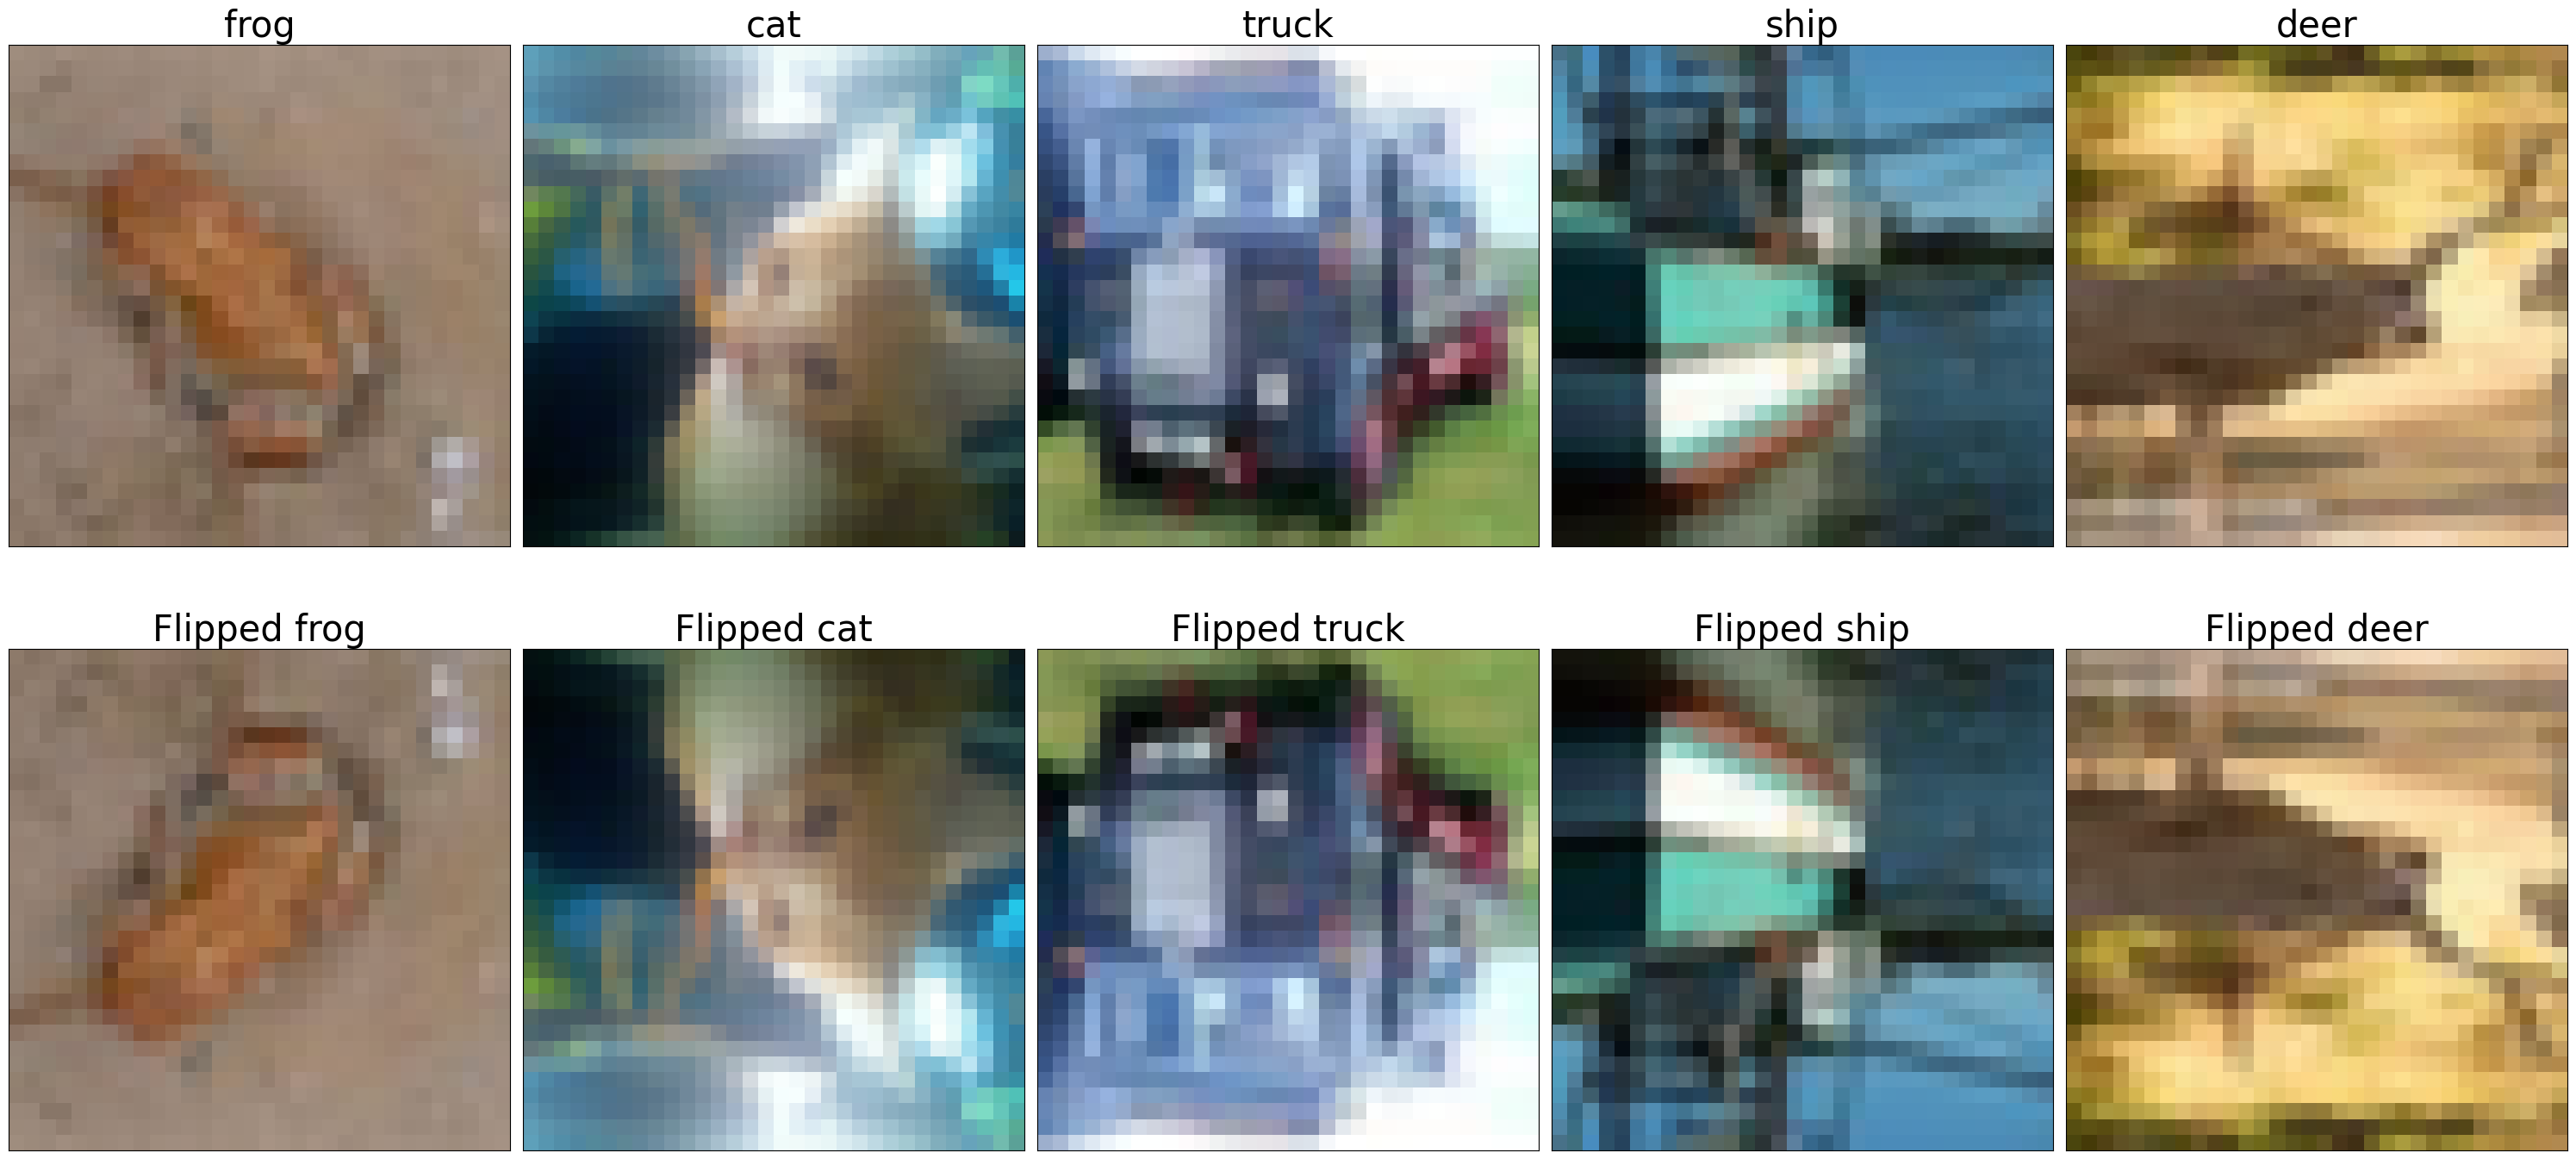

In [19]:
# load test set
dataset = CIFAR10(root=".", train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1)

# load some data
for x, y in loader:
    break


# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])

for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

In [8]:
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.4914, 0.4822, 0.4465),
                 (0.247, 0.243, 0.261)),
])

train_tranforms = v2.Compose([
    v2.PILToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomCrop(size=32, padding=4),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.4914, 0.4822, 0.4465),
                 (0.247, 0.243, 0.261))
])

train_dataset_full = CIFAR10(root='.',
                             train=True,
                             download=True,
                             transform=train_tranforms)

test_dataset = CIFAR10(root='.',
                       train=False,
                       download=True,
                       transform=transforms)

val_ratio = 0.1
train_size = int((1 - val_ratio) * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

train_dataset, val_dataset = random_split(
    train_dataset_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False)

In [33]:
model = ConvNet(n_classes=10)
params = model.parameters()
learning_rate = 0.01
patience = 5
delta = 1e-2
optim = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)

logs = train(model, optim, scheduler, train_loader, val_loader, patience, delta)

Device: cuda
EPOCH 1


100%|██████████| 352/352 [00:21<00:00, 16.61it/s]


Training loss: 0.8987340331077576, Training accuracy: 0.5482
Val loss: 1.3050929307937622, Val accuracy: 0.44151111111111113
Accuracy increased. (0.000000 → 0.441511). Saving model...
EPOCH 2


100%|██████████| 352/352 [00:22<00:00, 15.46it/s]


Training loss: 0.757274329662323, Training accuracy: 0.6028
Val loss: 0.8245255351066589, Val accuracy: 0.5230444444444444
Accuracy increased. (0.441511 → 0.523044). Saving model...
EPOCH 3


100%|██████████| 352/352 [00:22<00:00, 15.78it/s]


Training loss: 0.6360739469528198, Training accuracy: 0.6582
Val loss: 1.010911464691162, Val accuracy: 0.5696962962962963
Accuracy increased. (0.523044 → 0.569696). Saving model...
EPOCH 4


100%|██████████| 352/352 [00:22<00:00, 15.91it/s]


Training loss: 0.802217960357666, Training accuracy: 0.6826
Val loss: 0.8898333311080933, Val accuracy: 0.60275
Accuracy increased. (0.569696 → 0.602750). Saving model...
EPOCH 5


100%|██████████| 352/352 [00:22<00:00, 15.81it/s]


Training loss: 0.8694825172424316, Training accuracy: 0.7042
Val loss: 0.8661080598831177, Val accuracy: 0.62768
Accuracy increased. (0.602750 → 0.627680). Saving model...
EPOCH 6


100%|██████████| 352/352 [00:22<00:00, 15.72it/s]


Training loss: 0.36937081813812256, Training accuracy: 0.7202
Val loss: 0.7196173071861267, Val accuracy: 0.6475296296296297
Accuracy increased. (0.627680 → 0.647530). Saving model...
EPOCH 7


100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Training loss: 0.26925212144851685, Training accuracy: 0.7354
Val loss: 0.8231040239334106, Val accuracy: 0.6639809523809523
Accuracy increased. (0.647530 → 0.663981). Saving model...
EPOCH 8


100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Training loss: 0.4133612811565399, Training accuracy: 0.7542
Val loss: 0.5091158747673035, Val accuracy: 0.6783888888888889
Accuracy increased. (0.663981 → 0.678389). Saving model...
EPOCH 9


100%|██████████| 352/352 [00:21<00:00, 16.04it/s]


Training loss: 0.6628291606903076, Training accuracy: 0.7692
Val loss: 0.6733338832855225, Val accuracy: 0.6903925925925926
Accuracy increased. (0.678389 → 0.690393). Saving model...
EPOCH 10


100%|██████████| 352/352 [00:22<00:00, 15.98it/s]


Training loss: 0.43382754921913147, Training accuracy: 0.7566
Val loss: 0.8481502532958984, Val accuracy: 0.7012644444444445
Accuracy increased. (0.690393 → 0.701264). Saving model...
EPOCH 11


100%|██████████| 352/352 [00:22<00:00, 16.00it/s]


Training loss: 0.12235075235366821, Training accuracy: 0.7838
Val loss: 0.5527472496032715, Val accuracy: 0.7111090909090909
EarlyStopping counter: 1 out of 5
EPOCH 12


100%|██████████| 352/352 [00:21<00:00, 16.13it/s]


Training loss: 0.3125373125076294, Training accuracy: 0.781
Val loss: 0.5210490822792053, Val accuracy: 0.7200796296296297
Accuracy increased. (0.701264 → 0.720080). Saving model...
EPOCH 13


100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Training loss: 0.22333034873008728, Training accuracy: 0.7874
Val loss: 0.5992169976234436, Val accuracy: 0.7279623931623932
EarlyStopping counter: 1 out of 5
EPOCH 14


100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Training loss: 0.36507630348205566, Training accuracy: 0.7944
Val loss: 0.5703783631324768, Val accuracy: 0.7351936507936508
Accuracy increased. (0.720080 → 0.735194). Saving model...
EPOCH 15


100%|██████████| 352/352 [00:21<00:00, 16.05it/s]


Training loss: 0.14343109726905823, Training accuracy: 0.8084
Val loss: 0.6282151937484741, Val accuracy: 0.7418844444444445
EarlyStopping counter: 1 out of 5
EPOCH 16


100%|██████████| 352/352 [00:22<00:00, 15.90it/s]


Training loss: 0.5078362226486206, Training accuracy: 0.8006
Val loss: 0.40925484895706177, Val accuracy: 0.7481319444444444
Accuracy increased. (0.735194 → 0.748132). Saving model...
EPOCH 17


100%|██████████| 352/352 [00:22<00:00, 15.98it/s]


Training loss: 0.11960546672344208, Training accuracy: 0.8074
Val loss: 0.46040964126586914, Val accuracy: 0.7539921568627451
EarlyStopping counter: 1 out of 5
EPOCH 18


100%|██████████| 352/352 [00:21<00:00, 16.42it/s]


Training loss: 0.2846297025680542, Training accuracy: 0.8152
Val loss: 0.44729936122894287, Val accuracy: 0.7592888888888889
Accuracy increased. (0.748132 → 0.759289). Saving model...
EPOCH 19


100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Training loss: 0.5299086570739746, Training accuracy: 0.8108
Val loss: 0.3485119044780731, Val accuracy: 0.764306432748538
EarlyStopping counter: 1 out of 5
EPOCH 20


100%|██████████| 352/352 [00:21<00:00, 16.48it/s]


Training loss: 0.3290395140647888, Training accuracy: 0.814
Val loss: 0.5224093794822693, Val accuracy: 0.7689966666666667
EarlyStopping counter: 2 out of 5
EPOCH 21


100%|██████████| 352/352 [00:21<00:00, 16.15it/s]


Training loss: 0.21359999477863312, Training accuracy: 0.8076
Val loss: 0.46302318572998047, Val accuracy: 0.7734010582010582
Accuracy increased. (0.759289 → 0.773401). Saving model...
EPOCH 22


100%|██████████| 352/352 [00:22<00:00, 15.99it/s]


Training loss: 0.2349092960357666, Training accuracy: 0.8162
Val loss: 0.4006584882736206, Val accuracy: 0.7775636363636363
EarlyStopping counter: 1 out of 5
EPOCH 23


100%|██████████| 352/352 [00:22<00:00, 15.73it/s]


Training loss: 0.12021684646606445, Training accuracy: 0.82
Val loss: 0.3003363013267517, Val accuracy: 0.7814792270531401
EarlyStopping counter: 2 out of 5
EPOCH 24


100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Training loss: 0.2776474356651306, Training accuracy: 0.8208
Val loss: 0.38536781072616577, Val accuracy: 0.7850648148148148
Accuracy increased. (0.773401 → 0.785065). Saving model...
EPOCH 25


100%|██████████| 352/352 [00:21<00:00, 16.43it/s]


Training loss: 0.4716281592845917, Training accuracy: 0.8226
Val loss: 0.4362829625606537, Val accuracy: 0.7886035555555555
EarlyStopping counter: 1 out of 5
EPOCH 26


100%|██████████| 352/352 [00:21<00:00, 16.28it/s]


Training loss: 0.31614524126052856, Training accuracy: 0.8194
Val loss: 0.37019553780555725, Val accuracy: 0.7918965811965812
EarlyStopping counter: 2 out of 5
EPOCH 27


100%|██████████| 352/352 [00:21<00:00, 16.10it/s]


Training loss: 0.4613901972770691, Training accuracy: 0.8216
Val loss: 0.24782173335552216, Val accuracy: 0.7950098765432099
EarlyStopping counter: 3 out of 5
EPOCH 28


100%|██████████| 352/352 [00:22<00:00, 15.90it/s]


Training loss: 0.5745293498039246, Training accuracy: 0.8218
Val loss: 0.4452644884586334, Val accuracy: 0.7980603174603175
Accuracy increased. (0.785065 → 0.798060). Saving model...
EPOCH 29


100%|██████████| 352/352 [00:21<00:00, 16.18it/s]


Training loss: 0.19805553555488586, Training accuracy: 0.8196
Val loss: 0.25860750675201416, Val accuracy: 0.800872030651341
EarlyStopping counter: 1 out of 5
EPOCH 30


100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Training loss: 0.22150260210037231, Training accuracy: 0.8244
Val loss: 0.5957090854644775, Val accuracy: 0.8035985185185185
EarlyStopping counter: 2 out of 5
EPOCH 31


100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Training loss: 0.1382356435060501, Training accuracy: 0.823
Val loss: 0.6033400297164917, Val accuracy: 0.806126164874552
EarlyStopping counter: 3 out of 5
EPOCH 32


100%|██████████| 352/352 [00:21<00:00, 16.48it/s]


Training loss: 0.22565001249313354, Training accuracy: 0.8294
Val loss: 0.39948511123657227, Val accuracy: 0.8085541666666667
Accuracy increased. (0.798060 → 0.808554). Saving model...
EPOCH 33


100%|██████████| 352/352 [00:22<00:00, 15.99it/s]


Training loss: 0.08197786659002304, Training accuracy: 0.8294
Val loss: 0.32840049266815186, Val accuracy: 0.8108390572390572
EarlyStopping counter: 1 out of 5
EPOCH 34


100%|██████████| 352/352 [00:21<00:00, 16.12it/s]


Training loss: 0.2531619369983673, Training accuracy: 0.8282
Val loss: 0.3091973066329956, Val accuracy: 0.8130039215686274
EarlyStopping counter: 2 out of 5
EPOCH 35


100%|██████████| 352/352 [00:21<00:00, 16.03it/s]


Training loss: 0.16527977585792542, Training accuracy: 0.8246
Val loss: 0.307963103055954, Val accuracy: 0.8151250793650794
EarlyStopping counter: 3 out of 5
EPOCH 36


100%|██████████| 352/352 [00:21<00:00, 16.38it/s]


Training loss: 0.09343446791172028, Training accuracy: 0.824
Val loss: 0.2901328504085541, Val accuracy: 0.8171753086419753
EarlyStopping counter: 4 out of 5
EPOCH 37


100%|██████████| 352/352 [00:20<00:00, 17.16it/s]


Training loss: 0.3436274230480194, Training accuracy: 0.8234
Val loss: 0.30535566806793213, Val accuracy: 0.819051051051051
Accuracy increased. (0.808554 → 0.819051). Saving model...
EPOCH 38


100%|██████████| 352/352 [00:21<00:00, 16.26it/s]


Training loss: 0.3551512360572815, Training accuracy: 0.8248
Val loss: 0.38356614112854004, Val accuracy: 0.8209181286549707
EarlyStopping counter: 1 out of 5
EPOCH 39


100%|██████████| 352/352 [00:21<00:00, 16.09it/s]


Training loss: 0.09978996217250824, Training accuracy: 0.8282
Val loss: 0.31059667468070984, Val accuracy: 0.8226290598290599
EarlyStopping counter: 2 out of 5
EPOCH 40


100%|██████████| 352/352 [00:21<00:00, 16.52it/s]


Training loss: 0.4716495871543884, Training accuracy: 0.825
Val loss: 0.3616119623184204, Val accuracy: 0.8243022222222223
EarlyStopping counter: 3 out of 5
EPOCH 41


100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Training loss: 0.09314648061990738, Training accuracy: 0.8296
Val loss: 0.3560221195220947, Val accuracy: 0.8259219512195122
EarlyStopping counter: 4 out of 5
EPOCH 42


100%|██████████| 352/352 [00:20<00:00, 17.21it/s]


Training loss: 0.2700558006763458, Training accuracy: 0.8334
Val loss: 0.2893889248371124, Val accuracy: 0.8274624338624339
EarlyStopping counter: 5 out of 5
Early stopping triggered!


In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.functional.cross_entropy

best_model = ConvNet(n_classes=10)
best_model.load_state_dict(torch.load('checkpoint.pt'))
best_model.to(device)

test_loss, test_acc = evaluate(best_model, test_loader, loss_fn, device)

print(f"Best model accuracy on test set: {test_acc}")

Best model accuracy on test set: 0.8458


In [23]:
# Increase 77% -> 84%

In [25]:
model = ResNet(n_classes=10)
params = model.parameters()
learning_rate = 0.01
patience = 7
delta = 1e-2
optim = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)

logs = train(model, optim, scheduler, train_loader, val_loader, patience, delta)

Device: cuda
EPOCH 1


100%|██████████| 704/704 [00:19<00:00, 35.77it/s]


Training loss: 0.8005934953689575, Training accuracy: 0.5034
Val loss: 0.7662436366081238, Val accuracy: 0.4215111111111111
Accuracy increased. (0.000000 → 0.421511). Saving model...
EPOCH 2


100%|██████████| 704/704 [00:20<00:00, 34.15it/s]


Training loss: 1.3676605224609375, Training accuracy: 0.594
Val loss: 1.5393931865692139, Val accuracy: 0.5043111111111112
Accuracy increased. (0.421511 → 0.504311). Saving model...
EPOCH 3


100%|██████████| 704/704 [00:20<00:00, 33.87it/s]


Training loss: 0.9116570949554443, Training accuracy: 0.6494
Val loss: 1.018176794052124, Val accuracy: 0.5544074074074075
Accuracy increased. (0.504311 → 0.554407). Saving model...
EPOCH 4


100%|██████████| 704/704 [00:20<00:00, 33.67it/s]


Training loss: 1.650482177734375, Training accuracy: 0.6064
Val loss: 1.2706036567687988, Val accuracy: 0.5898
Accuracy increased. (0.554407 → 0.589800). Saving model...
EPOCH 5


100%|██████████| 704/704 [00:20<00:00, 34.51it/s]


Training loss: 0.5044153928756714, Training accuracy: 0.7128
Val loss: 0.9403611421585083, Val accuracy: 0.6176711111111111
Accuracy increased. (0.589800 → 0.617671). Saving model...
EPOCH 6


100%|██████████| 704/704 [00:20<00:00, 34.81it/s]


Training loss: 0.49267709255218506, Training accuracy: 0.7604
Val loss: 0.664728045463562, Val accuracy: 0.6411703703703704
Accuracy increased. (0.617671 → 0.641170). Saving model...
EPOCH 7


100%|██████████| 704/704 [00:20<00:00, 34.99it/s]


Training loss: 0.2820945680141449, Training accuracy: 0.768
Val loss: 0.7417109608650208, Val accuracy: 0.6612603174603174
Accuracy increased. (0.641170 → 0.661260). Saving model...
EPOCH 8


100%|██████████| 704/704 [00:21<00:00, 33.38it/s]


Training loss: 0.15084074437618256, Training accuracy: 0.789
Val loss: 0.3799906373023987, Val accuracy: 0.6788944444444445
Accuracy increased. (0.661260 → 0.678894). Saving model...
EPOCH 9


100%|██████████| 704/704 [00:21<00:00, 33.50it/s]


Training loss: 0.16382038593292236, Training accuracy: 0.8052
Val loss: 0.20997858047485352, Val accuracy: 0.6941777777777778
Accuracy increased. (0.678894 → 0.694178). Saving model...
EPOCH 10


100%|██████████| 704/704 [00:20<00:00, 33.61it/s]


Training loss: 0.32390397787094116, Training accuracy: 0.7818
Val loss: 0.2749199867248535, Val accuracy: 0.7077755555555556
Accuracy increased. (0.694178 → 0.707776). Saving model...
EPOCH 11


100%|██████████| 704/704 [00:19<00:00, 35.40it/s]


Training loss: 0.17120206356048584, Training accuracy: 0.8136
Val loss: 0.7729389667510986, Val accuracy: 0.7199717171717172
Accuracy increased. (0.707776 → 0.719972). Saving model...
EPOCH 12


100%|██████████| 704/704 [00:19<00:00, 35.48it/s]


Training loss: 0.07655300199985504, Training accuracy: 0.8214
Val loss: 0.5736428499221802, Val accuracy: 0.7309425925925926
Accuracy increased. (0.719972 → 0.730943). Saving model...
EPOCH 13


100%|██████████| 704/704 [00:20<00:00, 34.17it/s]


Training loss: 0.019589290022850037, Training accuracy: 0.833
Val loss: 0.09786665439605713, Val accuracy: 0.7410547008547008
Accuracy increased. (0.730943 → 0.741055). Saving model...
EPOCH 14


100%|██████████| 704/704 [00:20<00:00, 34.05it/s]


Training loss: 0.07497679442167282, Training accuracy: 0.8396
Val loss: 0.9166711568832397, Val accuracy: 0.7503460317460318
EarlyStopping counter: 1 out of 7
EPOCH 15


100%|██████████| 704/704 [00:20<00:00, 35.20it/s]


Training loss: 0.062240563333034515, Training accuracy: 0.8282
Val loss: 0.17940567433834076, Val accuracy: 0.7588088888888889
Accuracy increased. (0.741055 → 0.758809). Saving model...
EPOCH 16


100%|██████████| 704/704 [00:19<00:00, 35.77it/s]


Training loss: 0.05108647048473358, Training accuracy: 0.835
Val loss: 0.8912869691848755, Val accuracy: 0.7666097222222222
EarlyStopping counter: 1 out of 7
EPOCH 17


100%|██████████| 704/704 [00:20<00:00, 34.47it/s]


Training loss: 0.05793450027704239, Training accuracy: 0.8454
Val loss: 0.7378309369087219, Val accuracy: 0.7738980392156862
Accuracy increased. (0.758809 → 0.773898). Saving model...
EPOCH 18


100%|██████████| 704/704 [00:20<00:00, 33.64it/s]


Training loss: 0.043888840824365616, Training accuracy: 0.8538
Val loss: 0.08349291980266571, Val accuracy: 0.780662962962963
EarlyStopping counter: 1 out of 7
EPOCH 19


100%|██████████| 704/704 [00:20<00:00, 34.05it/s]


Training loss: 0.047744594514369965, Training accuracy: 0.853
Val loss: 0.5480799674987793, Val accuracy: 0.7870549707602339
Accuracy increased. (0.773898 → 0.787055). Saving model...
EPOCH 20


100%|██████████| 704/704 [00:19<00:00, 35.48it/s]


Training loss: 0.05152025818824768, Training accuracy: 0.8518
Val loss: 0.12444695830345154, Val accuracy: 0.7929722222222222
EarlyStopping counter: 1 out of 7
EPOCH 21


100%|██████████| 704/704 [00:19<00:00, 35.79it/s]


Training loss: 0.01971171423792839, Training accuracy: 0.8548
Val loss: 0.13118013739585876, Val accuracy: 0.7985015873015873
Accuracy increased. (0.787055 → 0.798502). Saving model...
EPOCH 22


100%|██████████| 704/704 [00:20<00:00, 33.65it/s]


Training loss: 0.03469870612025261, Training accuracy: 0.856
Val loss: 0.42236870527267456, Val accuracy: 0.803740404040404
EarlyStopping counter: 1 out of 7
EPOCH 23


100%|██████████| 704/704 [00:20<00:00, 33.74it/s]


Training loss: 0.019456852227449417, Training accuracy: 0.8546
Val loss: 0.9426490664482117, Val accuracy: 0.8086908212560386
Accuracy increased. (0.798502 → 0.808691). Saving model...
EPOCH 24


100%|██████████| 704/704 [00:20<00:00, 34.40it/s]


Training loss: 0.03199344128370285, Training accuracy: 0.855
Val loss: 0.6628354787826538, Val accuracy: 0.8133685185185185
EarlyStopping counter: 1 out of 7
EPOCH 25


100%|██████████| 704/704 [00:19<00:00, 35.91it/s]


Training loss: 0.0532623715698719, Training accuracy: 0.858
Val loss: 0.8913785219192505, Val accuracy: 0.8177866666666667
EarlyStopping counter: 2 out of 7
EPOCH 26


100%|██████████| 704/704 [00:20<00:00, 35.11it/s]


Training loss: 0.0637868195772171, Training accuracy: 0.8586
Val loss: 0.3006700277328491, Val accuracy: 0.8219384615384615
Accuracy increased. (0.808691 → 0.821938). Saving model...
EPOCH 27


100%|██████████| 704/704 [00:20<00:00, 33.89it/s]


Training loss: 0.02748652920126915, Training accuracy: 0.8618
Val loss: 0.16348838806152344, Val accuracy: 0.8259679012345679
EarlyStopping counter: 1 out of 7
EPOCH 28


100%|██████████| 704/704 [00:21<00:00, 33.09it/s]


Training loss: 0.03340546041727066, Training accuracy: 0.856
Val loss: 0.15050002932548523, Val accuracy: 0.829734126984127
EarlyStopping counter: 2 out of 7
EPOCH 29


100%|██████████| 704/704 [00:20<00:00, 34.07it/s]


Training loss: 0.017990142107009888, Training accuracy: 0.8572
Val loss: 0.1249905452132225, Val accuracy: 0.8332712643678161
Accuracy increased. (0.821938 → 0.833271). Saving model...
EPOCH 30


100%|██████████| 704/704 [00:20<00:00, 34.62it/s]


Training loss: 0.08876634389162064, Training accuracy: 0.8572
Val loss: 0.7776247262954712, Val accuracy: 0.836682962962963
EarlyStopping counter: 1 out of 7
EPOCH 31


100%|██████████| 704/704 [00:20<00:00, 34.04it/s]


Training loss: 0.07044925540685654, Training accuracy: 0.8632
Val loss: 0.05064859986305237, Val accuracy: 0.8398573476702509
EarlyStopping counter: 2 out of 7
EPOCH 32


100%|██████████| 704/704 [00:20<00:00, 33.69it/s]


Training loss: 0.009334196336567402, Training accuracy: 0.8584
Val loss: 0.3309937119483948, Val accuracy: 0.84293125
EarlyStopping counter: 3 out of 7
EPOCH 33


100%|██████████| 704/704 [00:20<00:00, 33.70it/s]


Training loss: 0.11398974806070328, Training accuracy: 0.8634
Val loss: 0.5428892970085144, Val accuracy: 0.8458417508417508
Accuracy increased. (0.833271 → 0.845842). Saving model...
EPOCH 34


100%|██████████| 704/704 [00:20<00:00, 34.37it/s]


Training loss: 0.02664339169859886, Training accuracy: 0.8636
Val loss: 0.8535463213920593, Val accuracy: 0.8485718954248366
EarlyStopping counter: 1 out of 7
EPOCH 35


100%|██████████| 704/704 [00:20<00:00, 35.06it/s]


Training loss: 0.02429712936282158, Training accuracy: 0.8608
Val loss: 0.6099115610122681, Val accuracy: 0.8512457142857143
EarlyStopping counter: 2 out of 7
EPOCH 36


100%|██████████| 704/704 [00:20<00:00, 34.70it/s]


Training loss: 0.0247957743704319, Training accuracy: 0.8672
Val loss: 1.719858169555664, Val accuracy: 0.853804938271605
EarlyStopping counter: 3 out of 7
EPOCH 37


100%|██████████| 704/704 [00:21<00:00, 32.68it/s]


Training loss: 0.035079777240753174, Training accuracy: 0.867
Val loss: 0.3275730311870575, Val accuracy: 0.856236036036036
Accuracy increased. (0.845842 → 0.856236). Saving model...
EPOCH 38


100%|██████████| 704/704 [00:20<00:00, 33.64it/s]


Training loss: 0.013085626065731049, Training accuracy: 0.8568
Val loss: 0.23953549563884735, Val accuracy: 0.8585654970760234
EarlyStopping counter: 1 out of 7
EPOCH 39


100%|██████████| 704/704 [00:20<00:00, 33.57it/s]


Training loss: 0.02148594707250595, Training accuracy: 0.8612
Val loss: 0.4821194112300873, Val accuracy: 0.860782905982906
EarlyStopping counter: 2 out of 7
EPOCH 40


100%|██████████| 704/704 [00:20<00:00, 35.13it/s]


Training loss: 0.08766108006238937, Training accuracy: 0.864
Val loss: 0.295286625623703, Val accuracy: 0.8629272222222222
EarlyStopping counter: 3 out of 7
EPOCH 41


100%|██████████| 704/704 [00:20<00:00, 35.18it/s]


Training loss: 0.046211183071136475, Training accuracy: 0.8642
Val loss: 0.8587647676467896, Val accuracy: 0.8649322493224932
EarlyStopping counter: 4 out of 7
EPOCH 42


100%|██████████| 704/704 [00:20<00:00, 33.77it/s]


Training loss: 0.049838367849588394, Training accuracy: 0.8632
Val loss: 0.012095307931303978, Val accuracy: 0.8668714285714286
Accuracy increased. (0.856236 → 0.866871). Saving model...
EPOCH 43


100%|██████████| 704/704 [00:20<00:00, 33.53it/s]


Training loss: 0.040847048163414, Training accuracy: 0.8638
Val loss: 0.11950931698083878, Val accuracy: 0.8687297157622739
EarlyStopping counter: 1 out of 7
EPOCH 44


100%|██████████| 704/704 [00:20<00:00, 33.55it/s]


Training loss: 0.050475478172302246, Training accuracy: 0.865
Val loss: 0.19444380700588226, Val accuracy: 0.8705434343434344
EarlyStopping counter: 2 out of 7
EPOCH 45


100%|██████████| 704/704 [00:20<00:00, 34.84it/s]


Training loss: 0.0338803306221962, Training accuracy: 0.8666
Val loss: 0.14620934426784515, Val accuracy: 0.8722666666666666
EarlyStopping counter: 3 out of 7
EPOCH 46


100%|██████████| 704/704 [00:20<00:00, 35.11it/s]


Training loss: 0.019370054826140404, Training accuracy: 0.8642
Val loss: 0.12608502805233002, Val accuracy: 0.8739144927536232
EarlyStopping counter: 4 out of 7
EPOCH 47


100%|██████████| 704/704 [00:21<00:00, 33.37it/s]


Training loss: 0.1392667293548584, Training accuracy: 0.8608
Val loss: 0.7430585026741028, Val accuracy: 0.8755172576832151
EarlyStopping counter: 5 out of 7
EPOCH 48


100%|██████████| 704/704 [00:20<00:00, 33.65it/s]


Training loss: 0.08894691616296768, Training accuracy: 0.8648
Val loss: 0.15781641006469727, Val accuracy: 0.8770412037037038
Accuracy increased. (0.866871 → 0.877041). Saving model...
EPOCH 49


100%|██████████| 704/704 [00:20<00:00, 33.83it/s]


Training loss: 0.14768409729003906, Training accuracy: 0.8668
Val loss: 0.5071223378181458, Val accuracy: 0.8785419501133787
EarlyStopping counter: 1 out of 7
EPOCH 50


100%|██████████| 704/704 [00:19<00:00, 35.42it/s]


Training loss: 0.04872474819421768, Training accuracy: 0.8636
Val loss: 0.12023073434829712, Val accuracy: 0.8799897777777778
EarlyStopping counter: 2 out of 7
EPOCH 51


100%|██████████| 704/704 [00:20<00:00, 35.06it/s]


Training loss: 0.06238006055355072, Training accuracy: 0.8674
Val loss: 0.04863649606704712, Val accuracy: 0.8813616557734205
EarlyStopping counter: 3 out of 7
EPOCH 52


100%|██████████| 704/704 [00:21<00:00, 33.46it/s]


Training loss: 0.014637029729783535, Training accuracy: 0.865
Val loss: 0.09800387918949127, Val accuracy: 0.8826448717948718
EarlyStopping counter: 4 out of 7
EPOCH 53


100%|██████████| 704/704 [00:20<00:00, 33.79it/s]


Training loss: 0.01364061702042818, Training accuracy: 0.8612
Val loss: 0.011467439122498035, Val accuracy: 0.8839190775681341
EarlyStopping counter: 5 out of 7
EPOCH 54


100%|██████████| 704/704 [00:20<00:00, 34.67it/s]


Training loss: 0.034636519849300385, Training accuracy: 0.866
Val loss: 0.17156222462654114, Val accuracy: 0.8851666666666667
EarlyStopping counter: 6 out of 7
EPOCH 55


100%|██████████| 704/704 [00:19<00:00, 35.21it/s]


Training loss: 0.020221630111336708, Training accuracy: 0.862
Val loss: 0.41569456458091736, Val accuracy: 0.8863680808080808
EarlyStopping counter: 7 out of 7
Early stopping triggered!


In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.functional.cross_entropy

best_model = ResNet(n_classes=10)
best_model.load_state_dict(torch.load('checkpoint.pt'))
best_model.to(device)

test_loss, test_acc = evaluate(best_model, test_loader, loss_fn, device)

print(f"Best model accuracy on test set: {test_acc}")

Best model accuracy on test set: 0.8595


In [ ]:
# Increase 83% -> 86%

In [9]:
class ResNetBlock(torch.nn.Module):
    def __init__(self, n_channels, stride=1, kernel_size=3, use_1x1_conv=False):
        super(ResNetBlock, self).__init__()
        self.conv_1 = nn.LazyConv2d(n_channels, kernel_size=kernel_size, stride=stride, padding=1)
        self.bn_1 = nn.LazyBatchNorm2d()
        self.conv_2 = nn.LazyConv2d(n_channels, kernel_size=kernel_size, padding=1)
        self.bn_2 = nn.LazyBatchNorm2d()
        if use_1x1_conv:
            self.skip_conv = nn.LazyConv2d(n_channels, kernel_size=1, stride=stride)
        else:
            self.skip_conv = None

    def forward(self, x):
        y = self.conv_1(x)
        y = self.bn_1(y)
        y = F.relu(y)
        y = self.conv_2(y)
        y = self.bn_2(y)
        if self.skip_conv:
            x = self.skip_conv(x)
        y += x
        return F.relu(y)


class ResNet(torch.nn.Module):
    def __init__(self, n_classes):
        super(ResNet, self).__init__()
        self.conv_1 = nn.LazyConv2d(128, kernel_size=3, padding=2)
        self.bn_1 = nn.LazyBatchNorm2d()
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.blk_1 = ResNetBlock(64, use_1x1_conv=True)
        self.blk_2 = ResNetBlock(64)
        self.blk_3 = ResNetBlock(128, stride=2, use_1x1_conv=True)
        self.blk_4 = ResNetBlock(128)
        self.blk_5 = ResNetBlock(256, stride=2, use_1x1_conv=True)
        self.blk_6 = ResNetBlock(256)
        self.flatten = nn.Flatten()
        self.pool_2 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_1 = nn.LazyLinear(n_classes)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.pool_1(x)
        x = self.blk_1(x)
        x = self.blk_2(x)
        x = self.blk_3(x)
        x = self.blk_4(x)
        x = self.blk_5(x)
        x = self.blk_6(x)
        x = self.pool_2(x)
        x = self.flatten(x)
        x = self.fc_1(x)
        return x


In [14]:
# Larger ResNet + CosineAnnealing
model = ResNet(n_classes=10)
params = model.parameters()
learning_rate = 3e-4
patience = 7
delta = 1e-2
weight_decay=1e-4
optim = torch.optim.Adam(params, lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=100)

logs = train(model, optim, scheduler, train_loader, val_loader, patience, delta)

Device: cuda
EPOCH 1


100%|██████████| 352/352 [00:23<00:00, 15.07it/s]


Training loss: 0.8838828206062317, Training accuracy: 0.5532
Val loss: 1.0700308084487915, Val accuracy: 0.5074
Accuracy increased. (0.000000 → 0.507400). Saving model...
EPOCH 2


100%|██████████| 352/352 [00:24<00:00, 14.44it/s]


Training loss: 0.9275425672531128, Training accuracy: 0.6728
Val loss: 0.6363375186920166, Val accuracy: 0.5835666666666667
Accuracy increased. (0.507400 → 0.583567). Saving model...
EPOCH 3


100%|██████████| 352/352 [00:23<00:00, 15.01it/s]


Training loss: 0.46360576152801514, Training accuracy: 0.7268
Val loss: 0.7590693831443787, Val accuracy: 0.6311777777777777
Accuracy increased. (0.583567 → 0.631178). Saving model...
EPOCH 4


100%|██████████| 352/352 [00:27<00:00, 12.93it/s]


Training loss: 0.36249852180480957, Training accuracy: 0.749
Val loss: 0.7615707516670227, Val accuracy: 0.6648833333333334
Accuracy increased. (0.631178 → 0.664883). Saving model...
EPOCH 5


100%|██████████| 352/352 [00:23<00:00, 14.78it/s]


Training loss: 0.6988691091537476, Training accuracy: 0.7516
Val loss: 0.6740361452102661, Val accuracy: 0.6907822222222222
Accuracy increased. (0.664883 → 0.690782). Saving model...
EPOCH 6


100%|██████████| 352/352 [00:23<00:00, 14.76it/s]


Training loss: 0.3077431321144104, Training accuracy: 0.7776
Val loss: 0.6082292199134827, Val accuracy: 0.7108444444444444
Accuracy increased. (0.690782 → 0.710844). Saving model...
EPOCH 7


100%|██████████| 352/352 [00:23<00:00, 14.80it/s]


Training loss: 0.08366291224956512, Training accuracy: 0.7804
Val loss: 0.4768555462360382, Val accuracy: 0.7276444444444444
Accuracy increased. (0.710844 → 0.727644). Saving model...
EPOCH 8


100%|██████████| 352/352 [00:24<00:00, 14.62it/s]


Training loss: 0.09931528568267822, Training accuracy: 0.8164
Val loss: 0.5500110387802124, Val accuracy: 0.7415388888888889
Accuracy increased. (0.727644 → 0.741539). Saving model...
EPOCH 9


100%|██████████| 352/352 [00:24<00:00, 14.62it/s]


Training loss: 0.11885008215904236, Training accuracy: 0.8214
Val loss: 0.4670655429363251, Val accuracy: 0.7535728395061728
Accuracy increased. (0.741539 → 0.753573). Saving model...
EPOCH 10


100%|██████████| 352/352 [00:23<00:00, 14.76it/s]


Training loss: 0.30333155393600464, Training accuracy: 0.8128
Val loss: 0.6982015371322632, Val accuracy: 0.7641688888888889
Accuracy increased. (0.753573 → 0.764169). Saving model...
EPOCH 11


100%|██████████| 352/352 [00:24<00:00, 14.15it/s]


Training loss: 0.15832427144050598, Training accuracy: 0.831
Val loss: 0.35304921865463257, Val accuracy: 0.7734222222222222
EarlyStopping counter: 1 out of 7
EPOCH 12


100%|██████████| 352/352 [00:24<00:00, 14.52it/s]


Training loss: 0.09727887809276581, Training accuracy: 0.8336
Val loss: 0.373930960893631, Val accuracy: 0.7818796296296296
Accuracy increased. (0.764169 → 0.781880). Saving model...
EPOCH 13


100%|██████████| 352/352 [00:24<00:00, 14.32it/s]


Training loss: 0.11848438531160355, Training accuracy: 0.8338
Val loss: 0.34573280811309814, Val accuracy: 0.7896102564102564
EarlyStopping counter: 1 out of 7
EPOCH 14


100%|██████████| 352/352 [00:23<00:00, 14.85it/s]


Training loss: 0.00927677657455206, Training accuracy: 0.8484
Val loss: 0.38164934515953064, Val accuracy: 0.7964682539682539
Accuracy increased. (0.781880 → 0.796468). Saving model...
EPOCH 15


100%|██████████| 352/352 [00:23<00:00, 14.77it/s]


Training loss: 0.02728298492729664, Training accuracy: 0.8494
Val loss: 0.3458666205406189, Val accuracy: 0.8029051851851852
EarlyStopping counter: 1 out of 7
EPOCH 16


100%|██████████| 352/352 [00:24<00:00, 14.57it/s]


Training loss: 0.029045118018984795, Training accuracy: 0.8578
Val loss: 0.3578634262084961, Val accuracy: 0.8086638888888888
Accuracy increased. (0.796468 → 0.808664). Saving model...
EPOCH 17


100%|██████████| 352/352 [00:23<00:00, 14.70it/s]


Training loss: 0.02204211801290512, Training accuracy: 0.8394
Val loss: 0.3931659758090973, Val accuracy: 0.8141934640522875
EarlyStopping counter: 1 out of 7
EPOCH 18


100%|██████████| 352/352 [00:24<00:00, 14.58it/s]


Training loss: 0.01400801818817854, Training accuracy: 0.8506
Val loss: 0.2777807414531708, Val accuracy: 0.8192407407407407
Accuracy increased. (0.808664 → 0.819241). Saving model...
EPOCH 19


100%|██████████| 352/352 [00:24<00:00, 14.63it/s]


Training loss: 0.4976904094219208, Training accuracy: 0.864
Val loss: 0.288041353225708, Val accuracy: 0.8240374269005848
EarlyStopping counter: 1 out of 7
EPOCH 20


100%|██████████| 352/352 [00:23<00:00, 14.79it/s]


Training loss: 0.058450762182474136, Training accuracy: 0.8574
Val loss: 0.2327941507101059, Val accuracy: 0.8285366666666667
EarlyStopping counter: 2 out of 7
EPOCH 21


100%|██████████| 352/352 [00:23<00:00, 14.71it/s]


Training loss: 0.024875812232494354, Training accuracy: 0.86
Val loss: 0.4605996906757355, Val accuracy: 0.832778835978836
Accuracy increased. (0.819241 → 0.832779). Saving model...
EPOCH 22


100%|██████████| 352/352 [00:23<00:00, 14.83it/s]


Training loss: 0.003815076779574156, Training accuracy: 0.867
Val loss: 0.2743028998374939, Val accuracy: 0.836789898989899
EarlyStopping counter: 1 out of 7
EPOCH 23


100%|██████████| 352/352 [00:23<00:00, 14.77it/s]


Training loss: 0.04292139783501625, Training accuracy: 0.8672
Val loss: 0.32177087664604187, Val accuracy: 0.8405806763285024
EarlyStopping counter: 2 out of 7
EPOCH 24


100%|██████████| 352/352 [00:23<00:00, 14.84it/s]


Training loss: 0.007287213578820229, Training accuracy: 0.8616
Val loss: 0.24382632970809937, Val accuracy: 0.8441990740740741
Accuracy increased. (0.832779 → 0.844199). Saving model...
EPOCH 25


100%|██████████| 352/352 [00:23<00:00, 14.74it/s]


Training loss: 0.026326017454266548, Training accuracy: 0.8734
Val loss: 0.11464370787143707, Val accuracy: 0.8476684444444444
EarlyStopping counter: 1 out of 7
EPOCH 26


100%|██████████| 352/352 [00:23<00:00, 14.81it/s]


Training loss: 0.032456204295158386, Training accuracy: 0.8736
Val loss: 0.25770384073257446, Val accuracy: 0.8510205128205128
EarlyStopping counter: 2 out of 7
EPOCH 27


100%|██████████| 352/352 [00:23<00:00, 14.74it/s]


Training loss: 0.013883584178984165, Training accuracy: 0.868
Val loss: 0.1392909735441208, Val accuracy: 0.8542748971193416
Accuracy increased. (0.844199 → 0.854275). Saving model...
EPOCH 28


100%|██████████| 352/352 [00:23<00:00, 14.89it/s]


Training loss: 0.017786310985684395, Training accuracy: 0.8742
Val loss: 0.31032422184944153, Val accuracy: 0.8573333333333333
EarlyStopping counter: 1 out of 7
EPOCH 29


100%|██████████| 352/352 [00:23<00:00, 14.92it/s]


Training loss: 0.20549261569976807, Training accuracy: 0.863
Val loss: 0.13980762660503387, Val accuracy: 0.8602674329501916
EarlyStopping counter: 2 out of 7
EPOCH 30


100%|██████████| 352/352 [00:23<00:00, 14.82it/s]


Training loss: 0.013324211351573467, Training accuracy: 0.8776
Val loss: 0.13027872145175934, Val accuracy: 0.86306
EarlyStopping counter: 3 out of 7
EPOCH 31


100%|██████████| 352/352 [00:23<00:00, 14.91it/s]


Training loss: 0.0020725156646221876, Training accuracy: 0.881
Val loss: 0.33656883239746094, Val accuracy: 0.8657240143369176
Accuracy increased. (0.854275 → 0.865724). Saving model...
EPOCH 32


100%|██████████| 352/352 [00:23<00:00, 14.85it/s]


Training loss: 0.33502763509750366, Training accuracy: 0.8636
Val loss: 0.11380165070295334, Val accuracy: 0.8683201388888889
EarlyStopping counter: 1 out of 7
EPOCH 33


100%|██████████| 352/352 [00:23<00:00, 14.72it/s]


Training loss: 0.0057103391736745834, Training accuracy: 0.8744
Val loss: 0.16637784242630005, Val accuracy: 0.870895622895623
EarlyStopping counter: 2 out of 7
EPOCH 34


100%|██████████| 352/352 [00:23<00:00, 14.84it/s]


Training loss: 0.0019894298166036606, Training accuracy: 0.8854
Val loss: 0.17338766157627106, Val accuracy: 0.8733150326797385
EarlyStopping counter: 3 out of 7
EPOCH 35


100%|██████████| 352/352 [00:23<00:00, 14.87it/s]


Training loss: 0.006148793268948793, Training accuracy: 0.8814
Val loss: 0.124529629945755, Val accuracy: 0.8756603174603175
EarlyStopping counter: 4 out of 7
EPOCH 36


100%|██████████| 352/352 [00:23<00:00, 14.85it/s]


Training loss: 0.010013691149652004, Training accuracy: 0.8786
Val loss: 0.12328174710273743, Val accuracy: 0.8779320987654321
Accuracy increased. (0.865724 → 0.877932). Saving model...
EPOCH 37


100%|██████████| 352/352 [00:23<00:00, 14.71it/s]


Training loss: 0.037904322147369385, Training accuracy: 0.8726
Val loss: 0.14080357551574707, Val accuracy: 0.8800708708708709
EarlyStopping counter: 1 out of 7
EPOCH 38


100%|██████████| 352/352 [00:24<00:00, 14.44it/s]


Training loss: 0.014259284362196922, Training accuracy: 0.8772
Val loss: 0.16532482206821442, Val accuracy: 0.8822409356725146
EarlyStopping counter: 2 out of 7
EPOCH 39


100%|██████████| 352/352 [00:24<00:00, 14.42it/s]


Training loss: 0.18041640520095825, Training accuracy: 0.8786
Val loss: 0.07668277621269226, Val accuracy: 0.8843128205128206
EarlyStopping counter: 3 out of 7
EPOCH 40


100%|██████████| 352/352 [00:24<00:00, 14.55it/s]


Training loss: 0.010128415189683437, Training accuracy: 0.8806
Val loss: 0.10576331615447998, Val accuracy: 0.8863177777777778
EarlyStopping counter: 4 out of 7
EPOCH 41


100%|██████████| 352/352 [00:24<00:00, 14.52it/s]


Training loss: 0.013561954721808434, Training accuracy: 0.8866
Val loss: 0.08891744911670685, Val accuracy: 0.8882747967479675
Accuracy increased. (0.877932 → 0.888275). Saving model...
EPOCH 42


100%|██████████| 352/352 [00:24<00:00, 14.65it/s]


Training loss: 0.012368232011795044, Training accuracy: 0.8762
Val loss: 0.14080411195755005, Val accuracy: 0.8902222222222222
EarlyStopping counter: 1 out of 7
EPOCH 43


100%|██████████| 352/352 [00:23<00:00, 14.74it/s]


Training loss: 0.0023067714646458626, Training accuracy: 0.8882
Val loss: 0.13582397997379303, Val accuracy: 0.8920387596899225
EarlyStopping counter: 2 out of 7
EPOCH 44


100%|██████████| 352/352 [00:23<00:00, 14.75it/s]


Training loss: 0.007883535698056221, Training accuracy: 0.8818
Val loss: 0.022425279021263123, Val accuracy: 0.8938393939393939
EarlyStopping counter: 3 out of 7
EPOCH 45


100%|██████████| 352/352 [00:23<00:00, 14.74it/s]


Training loss: 0.10020672529935837, Training accuracy: 0.8854
Val loss: 0.16371101140975952, Val accuracy: 0.8955614814814815
EarlyStopping counter: 4 out of 7
EPOCH 46


100%|██████████| 352/352 [00:23<00:00, 14.74it/s]


Training loss: 0.007078563328832388, Training accuracy: 0.8918
Val loss: 0.05793645605444908, Val accuracy: 0.8972628019323672
EarlyStopping counter: 5 out of 7
EPOCH 47


100%|██████████| 352/352 [00:23<00:00, 14.76it/s]


Training loss: 0.013948696665465832, Training accuracy: 0.8802
Val loss: 0.07910798490047455, Val accuracy: 0.8989229314420804
Accuracy increased. (0.888275 → 0.898923). Saving model...
EPOCH 48


100%|██████████| 352/352 [00:23<00:00, 14.70it/s]


Training loss: 0.0036145546473562717, Training accuracy: 0.8854
Val loss: 0.09265980869531631, Val accuracy: 0.9005023148148148
EarlyStopping counter: 1 out of 7
EPOCH 49


100%|██████████| 352/352 [00:23<00:00, 14.78it/s]


Training loss: 0.008957636542618275, Training accuracy: 0.8856
Val loss: 0.1489698439836502, Val accuracy: 0.9020308390022675
EarlyStopping counter: 2 out of 7
EPOCH 50


100%|██████████| 352/352 [00:23<00:00, 14.79it/s]


Training loss: 0.543830394744873, Training accuracy: 0.8848
Val loss: 0.11840759217739105, Val accuracy: 0.9035528888888888
EarlyStopping counter: 3 out of 7
EPOCH 51


100%|██████████| 352/352 [00:23<00:00, 14.86it/s]


Training loss: 0.0010983434040099382, Training accuracy: 0.8948
Val loss: 0.06907165050506592, Val accuracy: 0.9050305010893246
EarlyStopping counter: 4 out of 7
EPOCH 52


100%|██████████| 352/352 [00:23<00:00, 14.85it/s]


Training loss: 0.323137104511261, Training accuracy: 0.8964
Val loss: 0.02333996444940567, Val accuracy: 0.9064863247863247
EarlyStopping counter: 5 out of 7
EPOCH 53


100%|██████████| 352/352 [00:23<00:00, 14.99it/s]


Training loss: 0.002106285188347101, Training accuracy: 0.8918
Val loss: 0.07769912481307983, Val accuracy: 0.9078989517819707
EarlyStopping counter: 6 out of 7
EPOCH 54


100%|██████████| 352/352 [00:23<00:00, 15.06it/s]


Training loss: 0.0025336509570479393, Training accuracy: 0.8916
Val loss: 0.059674009680747986, Val accuracy: 0.9092814814814815
Accuracy increased. (0.898923 → 0.909281). Saving model...
EPOCH 55


100%|██████████| 352/352 [00:23<00:00, 15.13it/s]


Training loss: 0.004094566218554974, Training accuracy: 0.8928
Val loss: 0.05165915936231613, Val accuracy: 0.9106189898989899
EarlyStopping counter: 1 out of 7
EPOCH 56


100%|██████████| 352/352 [00:23<00:00, 15.17it/s]


Training loss: 0.001069473335519433, Training accuracy: 0.8992
Val loss: 0.1108318418264389, Val accuracy: 0.9119448412698413
EarlyStopping counter: 2 out of 7
EPOCH 57


100%|██████████| 352/352 [00:23<00:00, 15.14it/s]


Training loss: 0.0003351076156832278, Training accuracy: 0.8962
Val loss: 0.03673601895570755, Val accuracy: 0.9132456140350877
EarlyStopping counter: 3 out of 7
EPOCH 58


100%|██████████| 352/352 [00:23<00:00, 15.23it/s]


Training loss: 0.0047371177934110165, Training accuracy: 0.8832
Val loss: 0.019779149442911148, Val accuracy: 0.9144977011494253
EarlyStopping counter: 4 out of 7
EPOCH 59


100%|██████████| 352/352 [00:23<00:00, 15.26it/s]


Training loss: 0.0016800519078969955, Training accuracy: 0.8906
Val loss: 0.17819872498512268, Val accuracy: 0.915723163841808
EarlyStopping counter: 5 out of 7
EPOCH 60


100%|██████████| 352/352 [00:23<00:00, 15.20it/s]


Training loss: 0.034329865127801895, Training accuracy: 0.8956
Val loss: 0.0627894476056099, Val accuracy: 0.9169007407407408
EarlyStopping counter: 6 out of 7
EPOCH 61


100%|██████████| 352/352 [00:23<00:00, 15.14it/s]


Training loss: 0.1622539758682251, Training accuracy: 0.899
Val loss: 0.005126231350004673, Val accuracy: 0.9180870673952641
EarlyStopping counter: 7 out of 7
Early stopping triggered!


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.functional.cross_entropy

best_model = ResNet(n_classes=10)
best_model.load_state_dict(torch.load('checkpoint.pt'))
best_model.to(device)

test_loss, test_acc = evaluate(best_model, test_loader, loss_fn, device)

print(f"Best model accuracy on test set: {test_acc}")

Best model accuracy on test set: 0.8908


In [16]:
# More layers: 86 -> 89%